Обращение к ревьюверу

# Описание:  
**Название проекта**

Проект: Второй сборный проект

**Описание исследования.**



**Цель исследования.**



**Действия, необходимые для достижения поставленной цели.**

Загрузить данные;  
Обработать;  
Проанализировать их;  
Выявить корреляции в данных;   
Подготовить данные для МО и обучить модель;  
Проверить метрики модели;
Выполнить предсказания используя модель;
Сделать вывод по проделанной работе;

**Исходные данные.**




**Данное исследование разделено по плану:**  
[1.Загрузка данных](#t001)  
[2. Предобработка данных](#t002)   
[3. Исследовательский анализ данныхъ](#t003)  
[4. Объединение таблиц](#t004)  
[5. Корреляционный анализ](#t005)  
[6. Использование пайплайнов](#t006)  
[7. Анализ важности признаков](#t007)  
[8. Сегментация покупателей](#t008)
[9. Общий вывод](#t009)

# 0. Подготовительные шаги и функции  


## Импортирую библиотеки

In [162]:
#%pip install phik
#%pip install shap
import os
import phik
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import kstest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder


## Объявляю константы  

In [163]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'
#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'
#список имен датафреймов 
DF_NAMES = ['df_test_features', 'df_test_target_job_satisfaction_rate', 'df_test_target_quit', 'df_train_job_satisfaction_rate', 'df_train_quit']
# конатстна новой строки для использования в f' строках
NL = '\n'

RANDOM_STATE = 42

## Объявляю функции

In [164]:
def smape(a, f):
 return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

<a id='t001'></a>
# 1. Загрузка данных 
## Для выполнения задачи заказчиком были переданы три набора данных  

Т.к. работу выполнял локально, в VScode добавил проверку где выполняется проект. Если не локально, то брать из расположения в тренажере.

## 1.1 Загрузка данных  

Решил немного упростить себе задачу и разложить данные из всех файлов по своим датафреймам сразу для первой и сторой задачи.

In [165]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f.strip('df_') + '.csv')
    elif os.path.exists(TRAINER_DATA_PATH):
         globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f.strip('df_') + '.csv')
    else:
        print('ALARMA! No files found!')

Посмотрю на то, что загрузилось.

In [166]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].sample(5).T)

Датасет df_test_features


,1495,1845,1268,1852,1527
id,637368,661638,854193,697274,303017
dept,technology,technology,technology,marketing,sales
level,middle,middle,junior,middle,junior
workload,medium,high,low,low,medium
employment_years,6,3,1,5,1
last_year_promo,no,no,no,no,no
last_year_violations,no,no,no,no,no
supervisor_evaluation,4,5,4,4,3
salary,50400,62400,15600,26400,21600


Датасет df_test_target_job_satisfaction_rate


,897,82,1957,771,1221
id,869744.00,292902.0,295032.00,795545.00,428285.0
job_satisfaction_rate,0.28,0.7,0.42,0.65,0.5


Датасет df_test_target_quit


,33,996,553,1720,453
id,449661,918633,117069,783127,449917
quit,yes,no,no,no,no


Датасет df_train_job_satisfaction_rate


,1634,1603,40,3752,2097
id,281466,426614,377249,441872,113614
dept,marketing,technology,sales,technology,technology
level,junior,middle,middle,junior,middle
workload,low,medium,high,medium,high
employment_years,2,2,3,4,6
last_year_promo,no,no,yes,no,no
last_year_violations,no,no,no,no,no
supervisor_evaluation,3,5,2,5,4
salary,16800,46800,46800,27600,68400
job_satisfaction_rate,0.58,0.66,0.3,0.72,0.88


Датасет df_train_quit


,3302,2896,2415,2776,455
id,727575,824346,176288,796157,680918
dept,technology,marketing,marketing,hr,hr
level,junior,junior,junior,middle,middle
workload,low,low,medium,medium,medium
employment_years,1,1,1,8,4
last_year_promo,no,no,no,no,no
last_year_violations,no,no,yes,no,no
supervisor_evaluation,5,4,4,2,4
salary,19200,13200,27600,43200,40800
quit,no,yes,yes,no,no


## 1.2 Проверка содержимого в загруженных данных

Просмотрел загруженные данные. Сверил их с описанием. Несоответствия описанным данным не обнаружил.

<a id='t002'></a>  
# 2. Предобработка данных

## Посмотрю соответствие типов столбцов описанным в задаче типам.

In [167]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].info(True))

Датасет df_test_features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Датасет df_test_target_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Датасет df_test_target_quit
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Датасет df_train_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Датасет df_train_quit
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Типы данных соответствуют хранимым ими данным. Пропуски наблюдаются в таблицах: **df_test_features, df_train_job_satisfaction_rate**. Их я буду обрабатывать позже, по условию задания, в паплайне.

## Проверю таблицы на дубликаты

##### Выведу список явных дубликатов

In [168]:
for f in DF_NAMES:
    print(f'В датасете {f} найдено дубликатов: {globals()[f].duplicated().sum()}')

В датасете df_test_features найдено дубликатов: 0
В датасете df_test_target_job_satisfaction_rate найдено дубликатов: 0
В датасете df_test_target_quit найдено дубликатов: 0
В датасете df_train_job_satisfaction_rate найдено дубликатов: 0
В датасете df_train_quit найдено дубликатов: 0


Явных нет. Поищу неявные.

Для каждой таблицы сформирую список столбцов с категоримальными данными, а остальные будут численными.

In [169]:
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_' + f.strip('df_')] = globals()[f].select_dtypes(include='object').columns.to_list()
    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_' + f.strip('df_')]]
    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

Столбцы датафрейма df_test_features
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_job_satisfaction_rate
Категориальные столбцы: 
 []
Численные столбцы: 
 ['id', 'job_satisfaction_rate'] 

Столбцы датафрейма df_test_target_quit
Категориальные столбцы: 
 ['quit']
Численные столбцы: 
 ['id'] 

Столбцы датафрейма df_train_job_satisfaction_rate
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Столбцы датафрейма df_train_quit
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Численные столбцы: 
 ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 



Взгляну на уникальные значения в категориальных столбцах. Не исключено, что в них могут быть очепятки и\или иные артефакты.

In [170]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    for c in globals()['col_cat_' + f.strip('df_')]:
        print(f"Уникальные значения столбца {c}:\n"  
              f"{(globals()[f][c]).unique()}")
    print('\n')

Датафрейм df_test_features
Уникальные значения столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'low' 'high' ' ']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_test_target_job_satisfaction_rate


Датафрейм df_test_target_quit
Уникальные значения столбца quit:
['yes' 'no']


Датафрейм df_train_job_satisfaction_rate
Уникальные значения столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'high' 'low']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_train_quit
Уникальные значения столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr

В **df_test_features** столбцы _dept, level и workload_, и в таблице **df_test_target_quit** столбец _dept_ содержат пропуски. Об этом было указано чуть раньше, а обработаю это в конвеере.

**Вывод:** данные в датафреймах не содержат явных или неявных дублей. Присутствуют пропуски.

<a id='t003'></a>  
# 3. Исследовательский анализ данных

### Выведу описательную статистику по каждой таблице

In [171]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    print(f"{(globals()[f]).describe()}")
        
    print('\n')

Датафрейм df_test_features
                  id  employment_years  supervisor_evaluation        salary
count    2000.000000       2000.000000            2000.000000   2000.000000
mean   552765.213500          3.666500               3.526500  34066.800000
std    253851.326129          2.537222               0.996892  15398.436729
min    100298.000000          1.000000               1.000000  12000.000000
25%    339052.000000          1.000000               3.000000  22800.000000
50%    550793.000000          3.000000               4.000000  30000.000000
75%    765763.750000          6.000000               4.000000  43200.000000
max    999029.000000         10.000000               5.000000  96000.000000


Датафрейм df_test_target_job_satisfaction_rate
                  id  job_satisfaction_rate
count    2000.000000             2000.00000
mean   552765.213500                0.54878
std    253851.326129                0.22011
min    100298.000000                0.03000
25%    339052.000000

По описательной статистике можно сказать, что аномалий в данных не наблюдаются. Значение дисперсии и среднего ожидаемые.

### Построю графики

#### Категориальные признаки

Гистограмма распределения значений для таблицы df_test_features


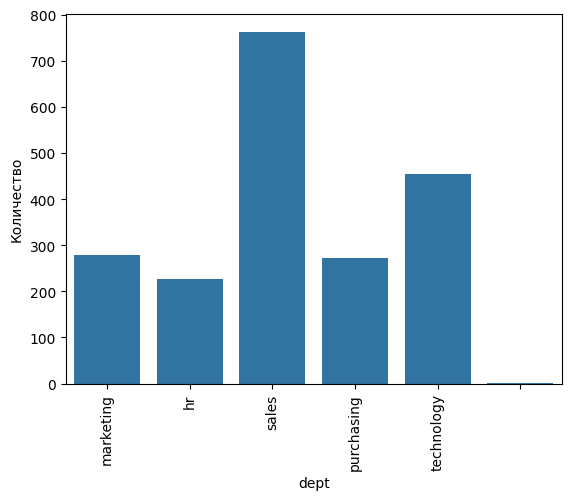

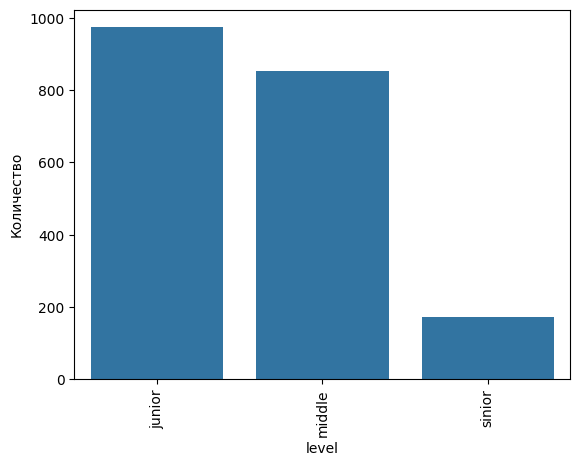

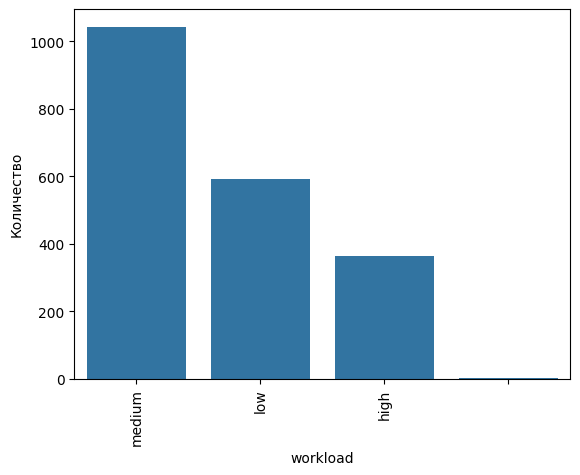

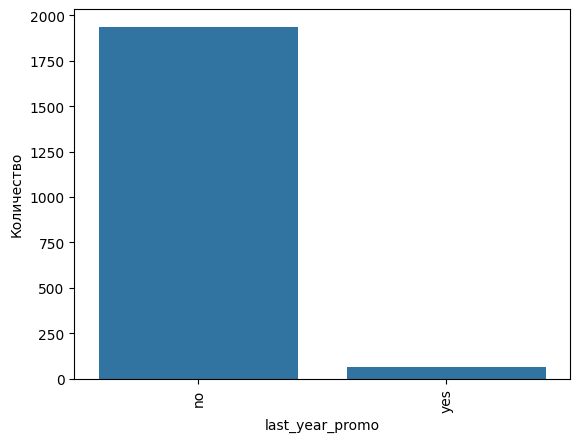

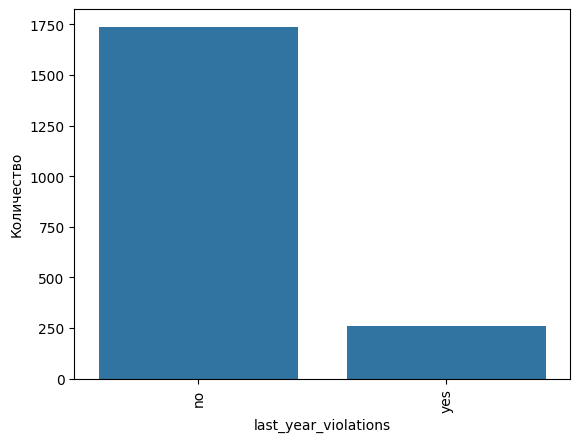

Гистограмма распределения значений для таблицы df_test_target_job_satisfaction_rate
Гистограмма распределения значений для таблицы df_test_target_quit


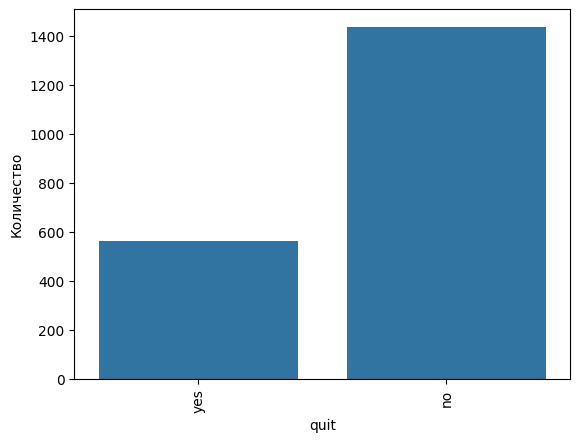

Гистограмма распределения значений для таблицы df_train_job_satisfaction_rate


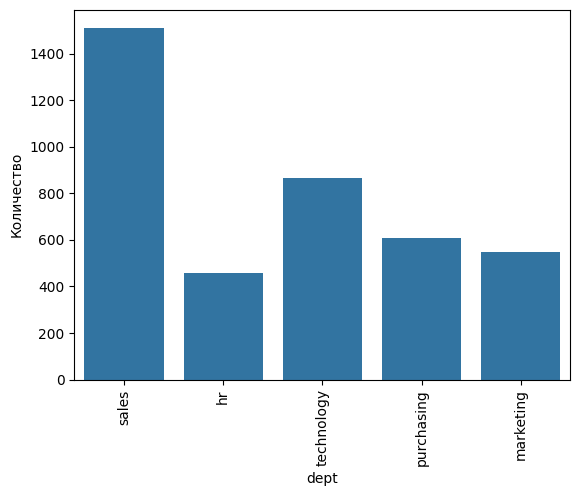

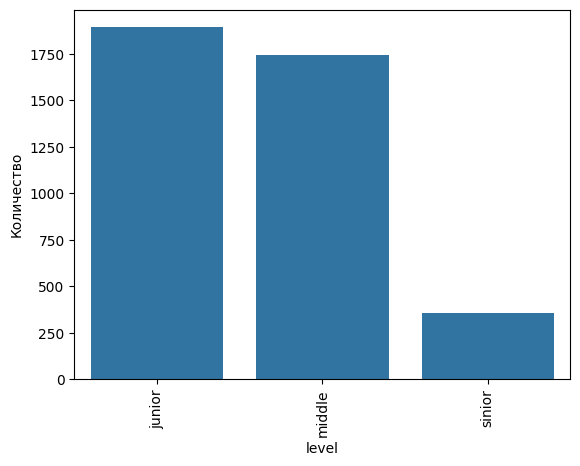

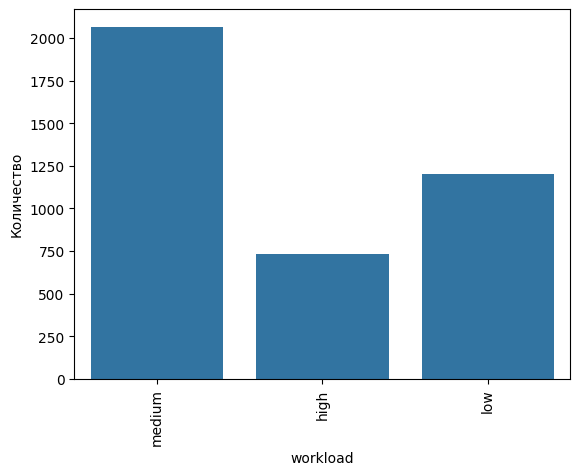

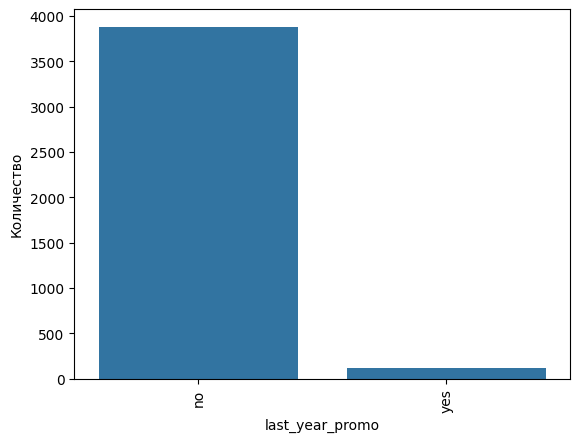

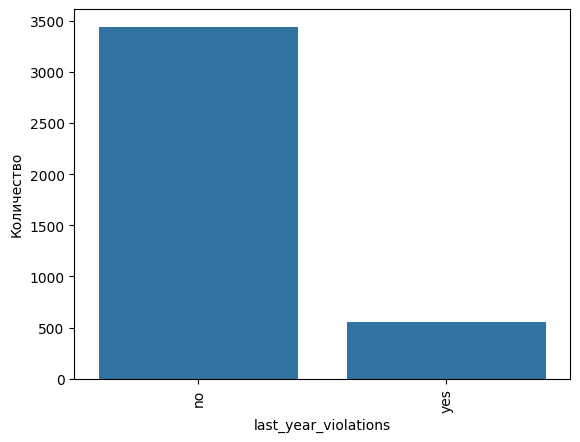

Гистограмма распределения значений для таблицы df_train_quit


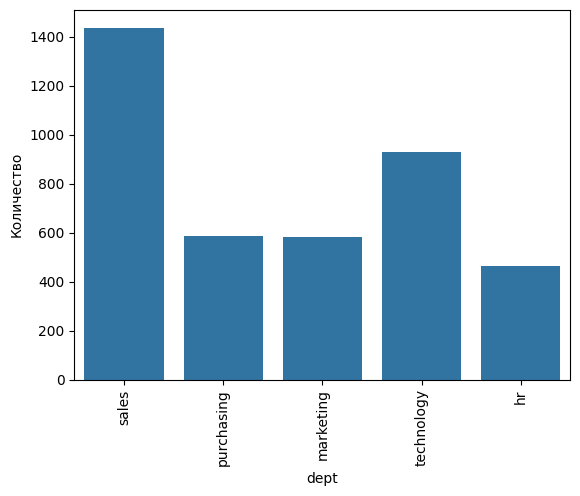

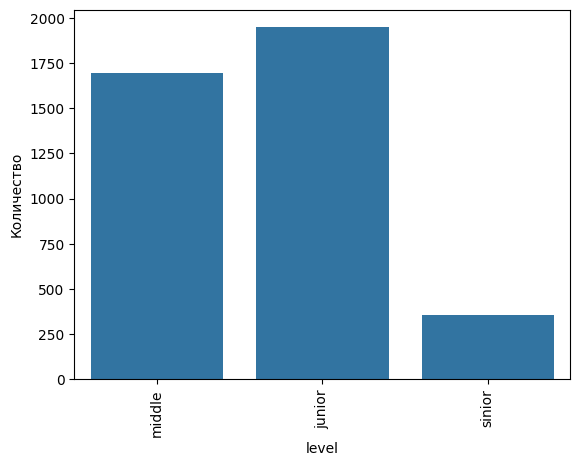

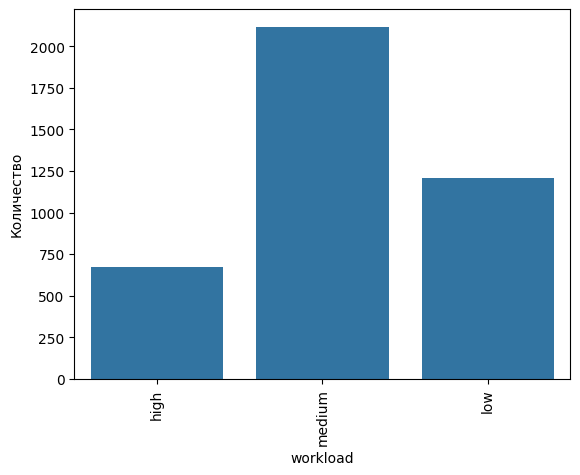

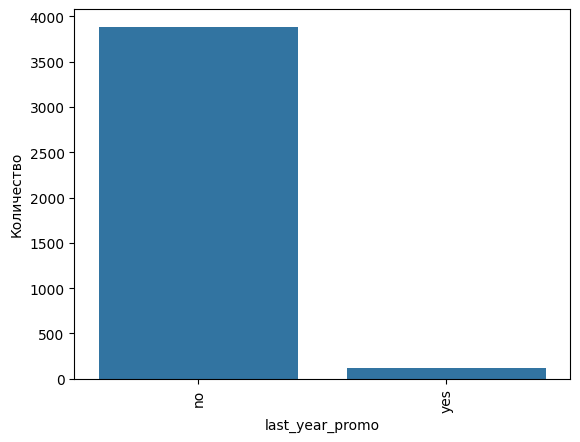

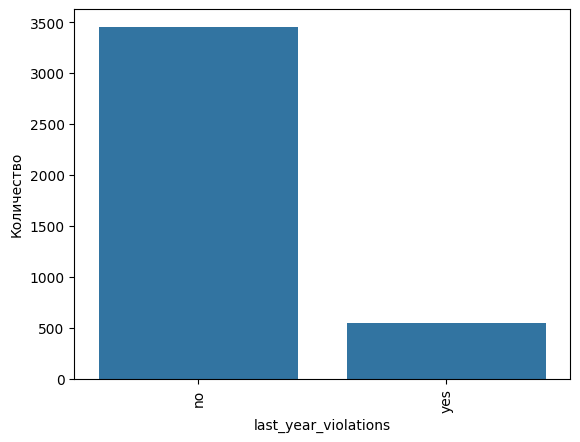

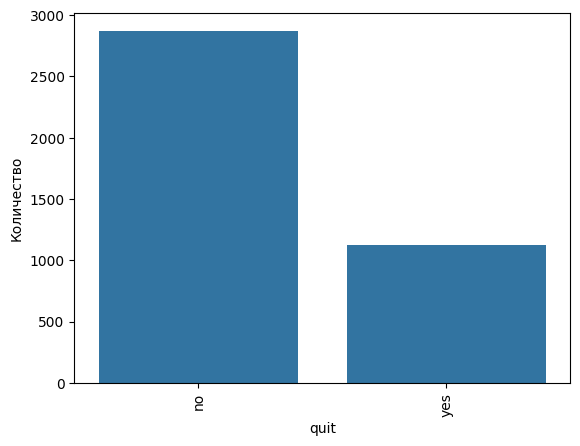

In [172]:
for f in DF_NAMES:
    print(f'Гистограмма распределения значений для таблицы {f}')
    for c in globals()['col_cat_' + f.strip('df_')]:
        ax = sns.countplot(x=c, data = globals()[f])
        ax.set(xlabel=c, ylabel='Количество')
        plt.xticks(rotation=90)
        plt.show()

По гистограммам можно сделать следующие наблюдения. Вцелом распределение данных поддается логике и ожидаемо. В наборе данных наблюдается сравнительно мизерное количество сотрудников с повышением ЗП. в таблице целевых признакам наблюдается дисбаланс признаков.

####  Построю для численных данных пару графиков гистограмму и ящик с усами, а заодно тест Колмогорова-Смирнова, чтобы получить нормальность распределения.

"Пара графиков для таблицы df_test_features


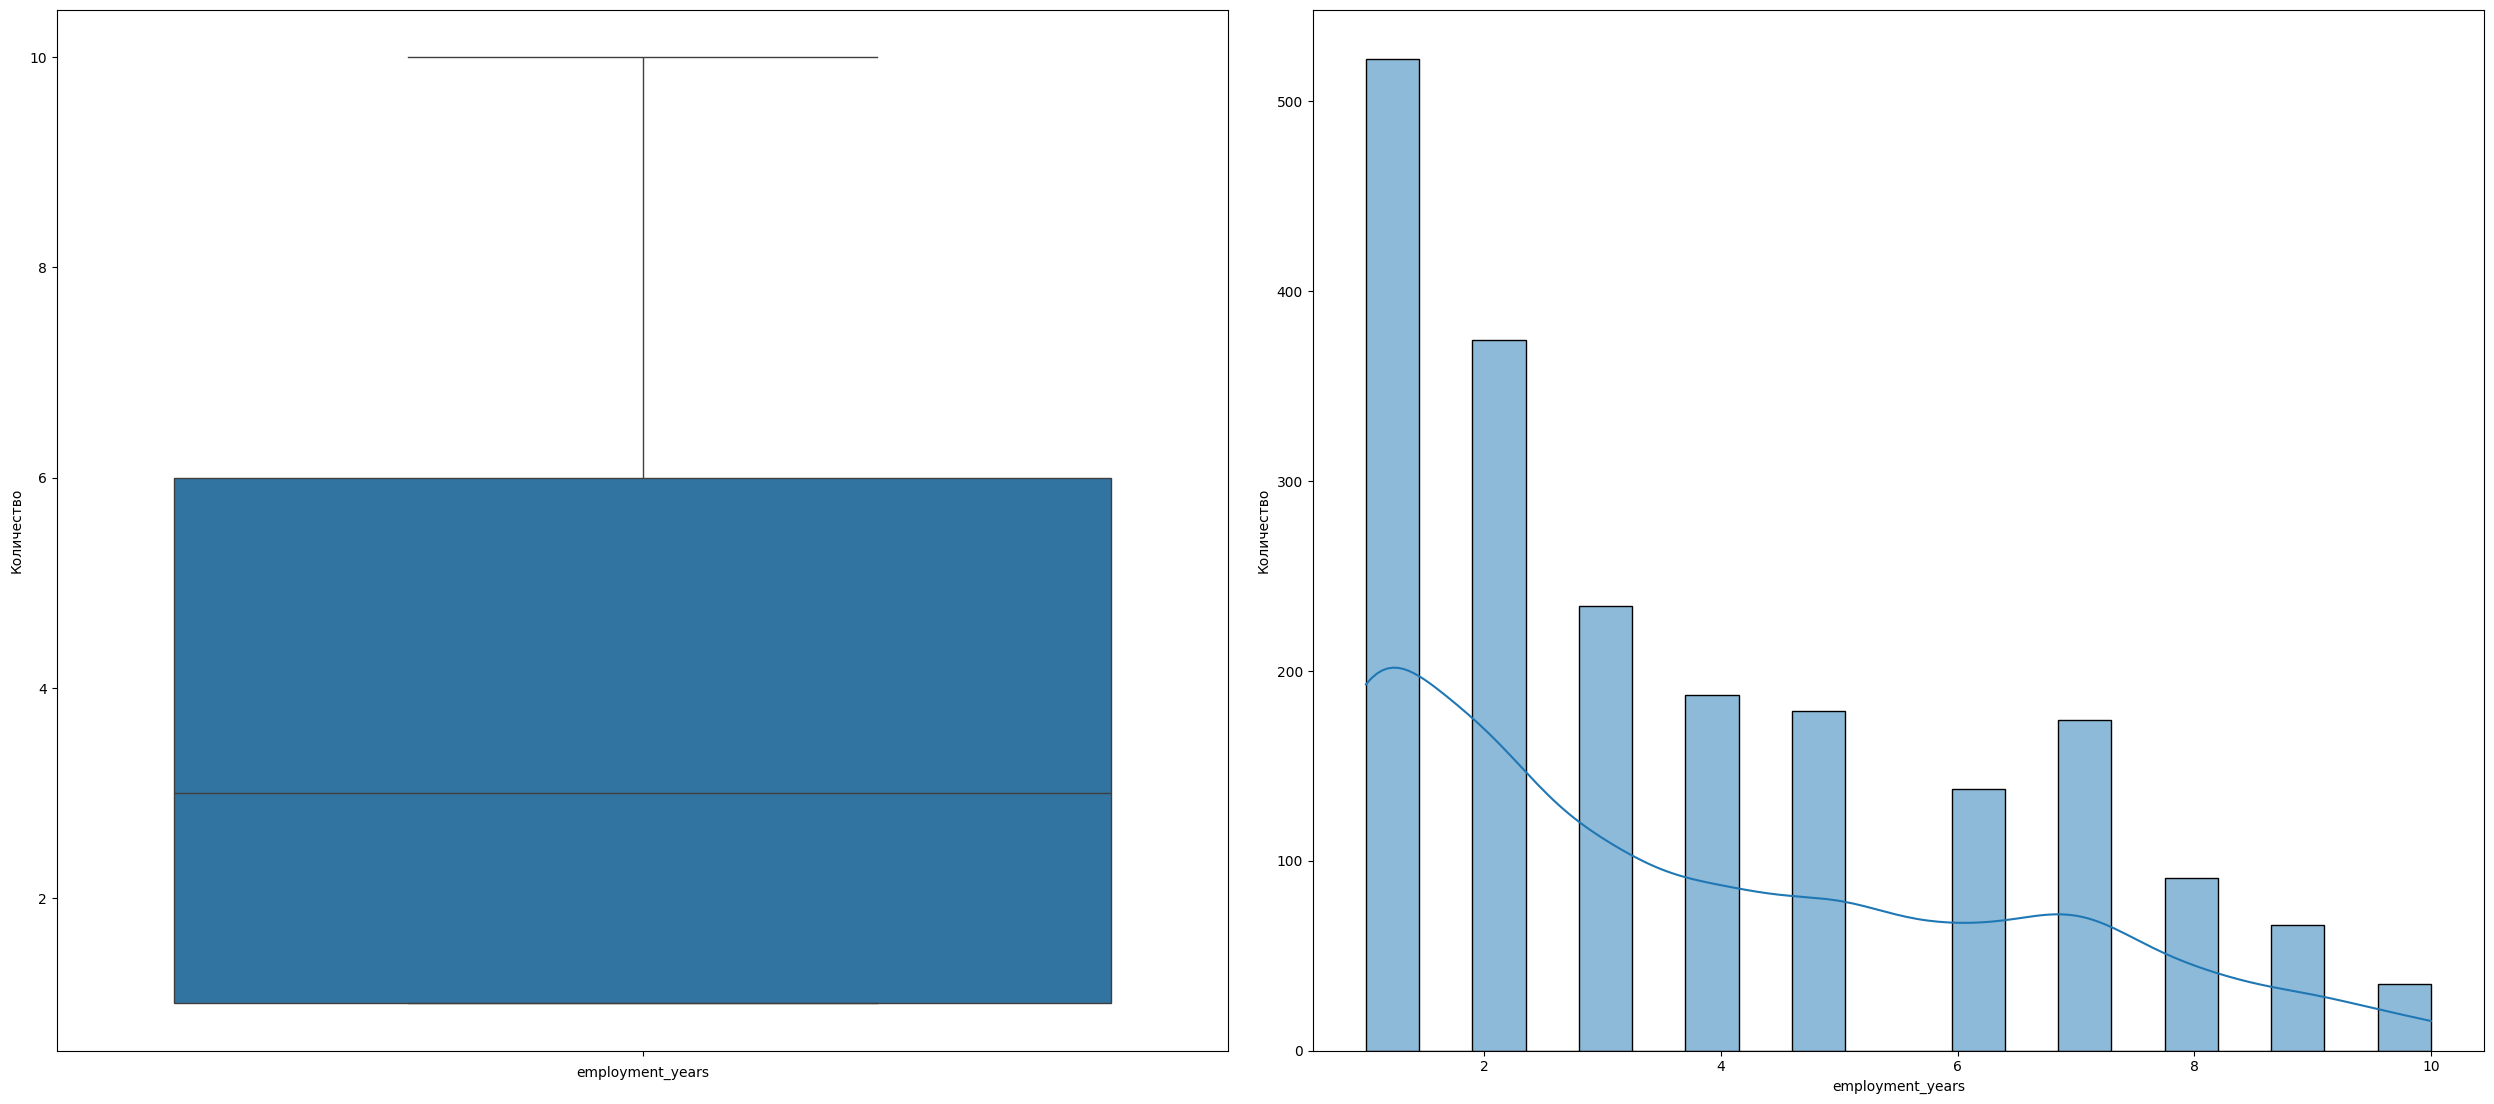

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


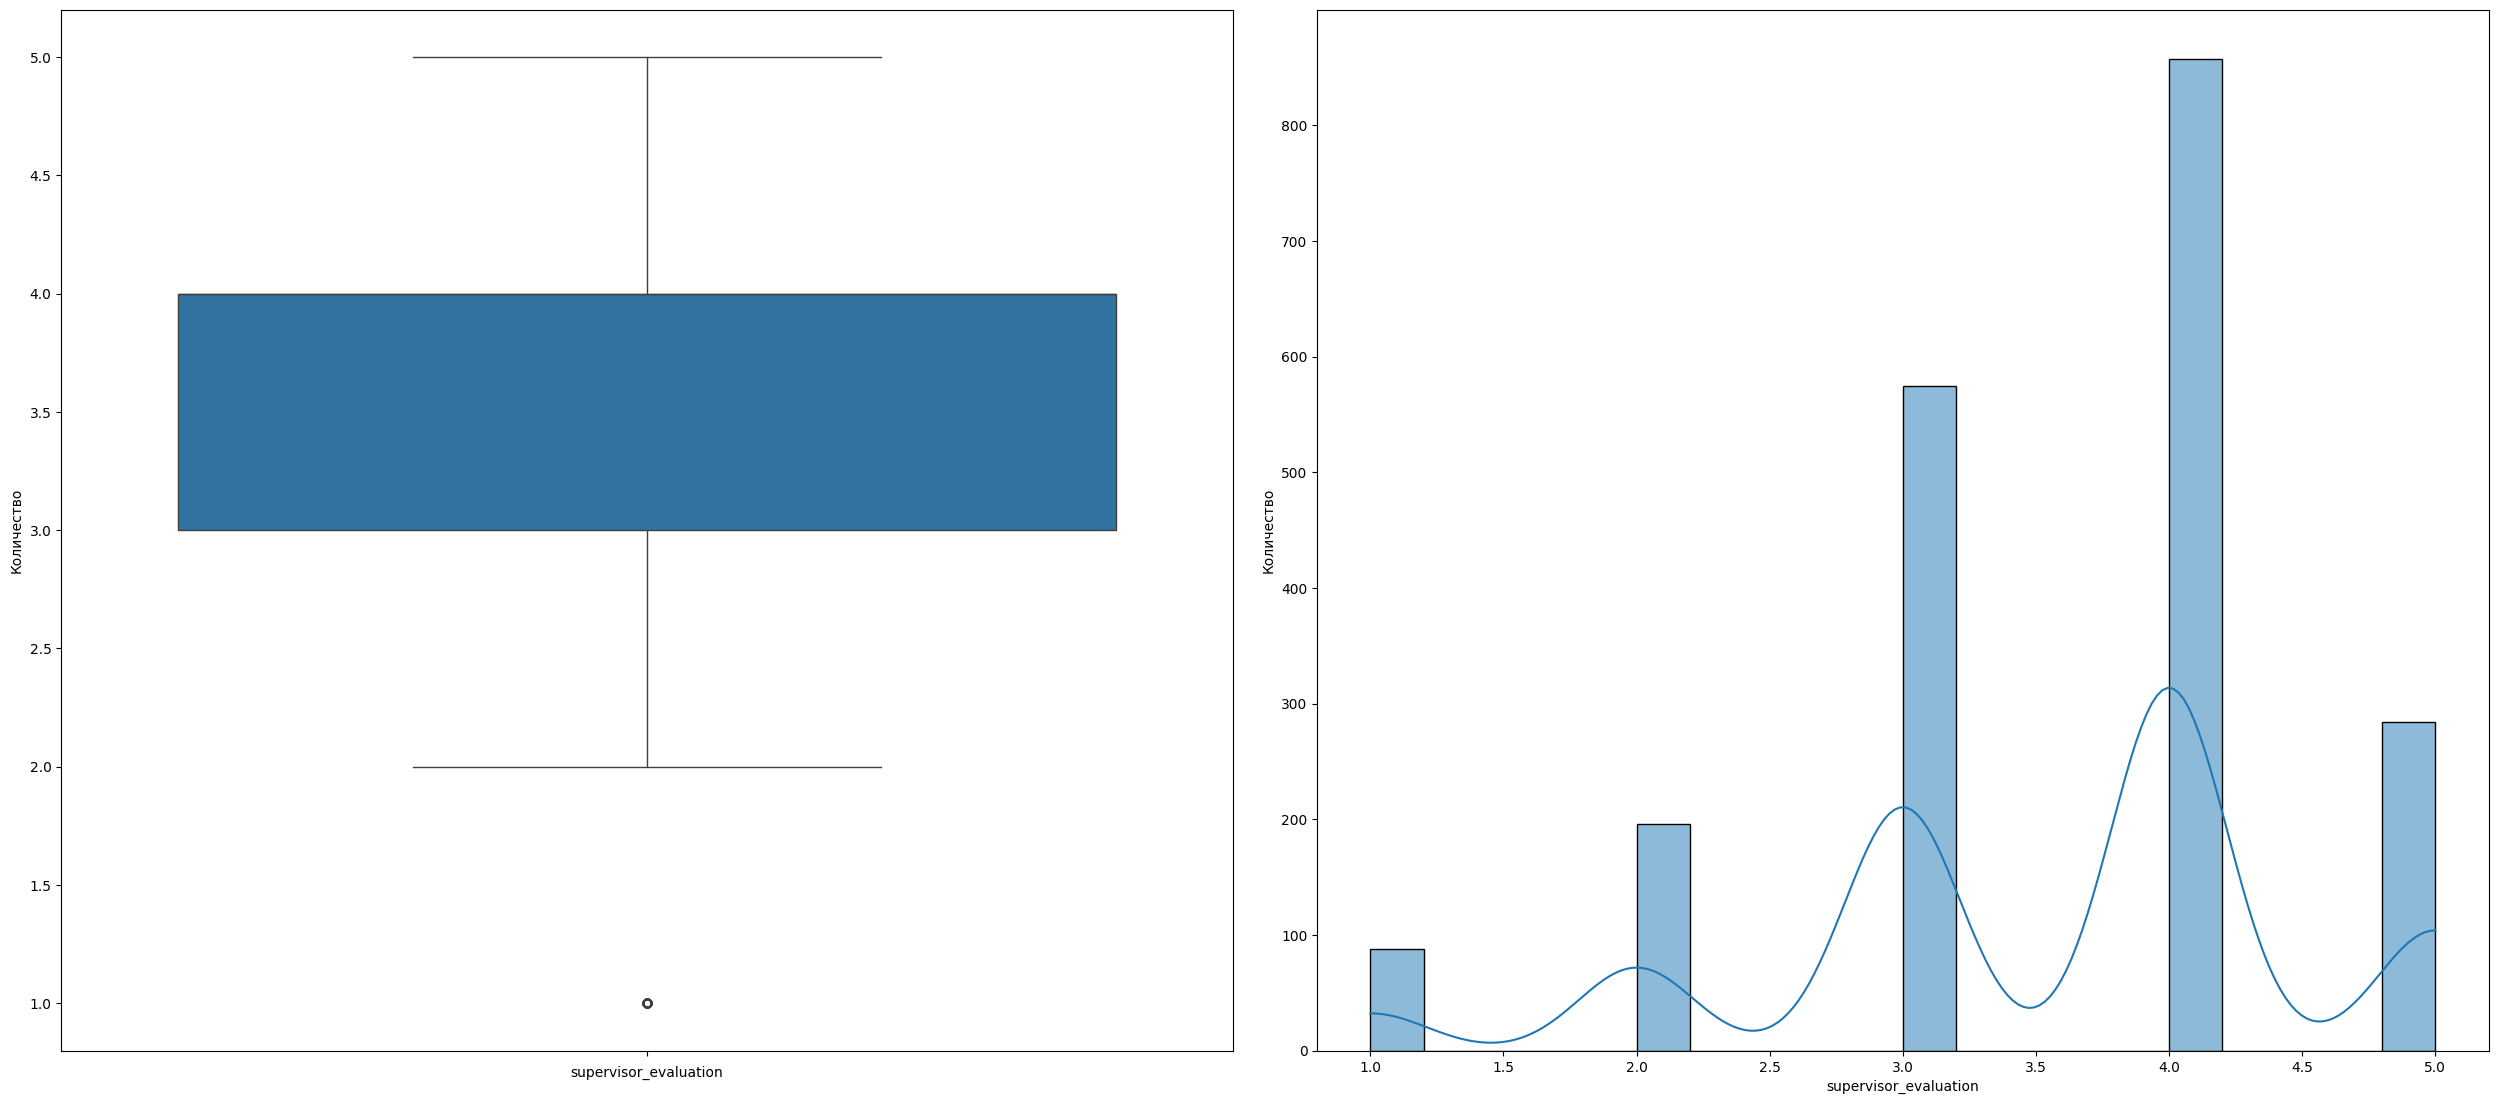

KstestResult(statistic=0.9332498680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


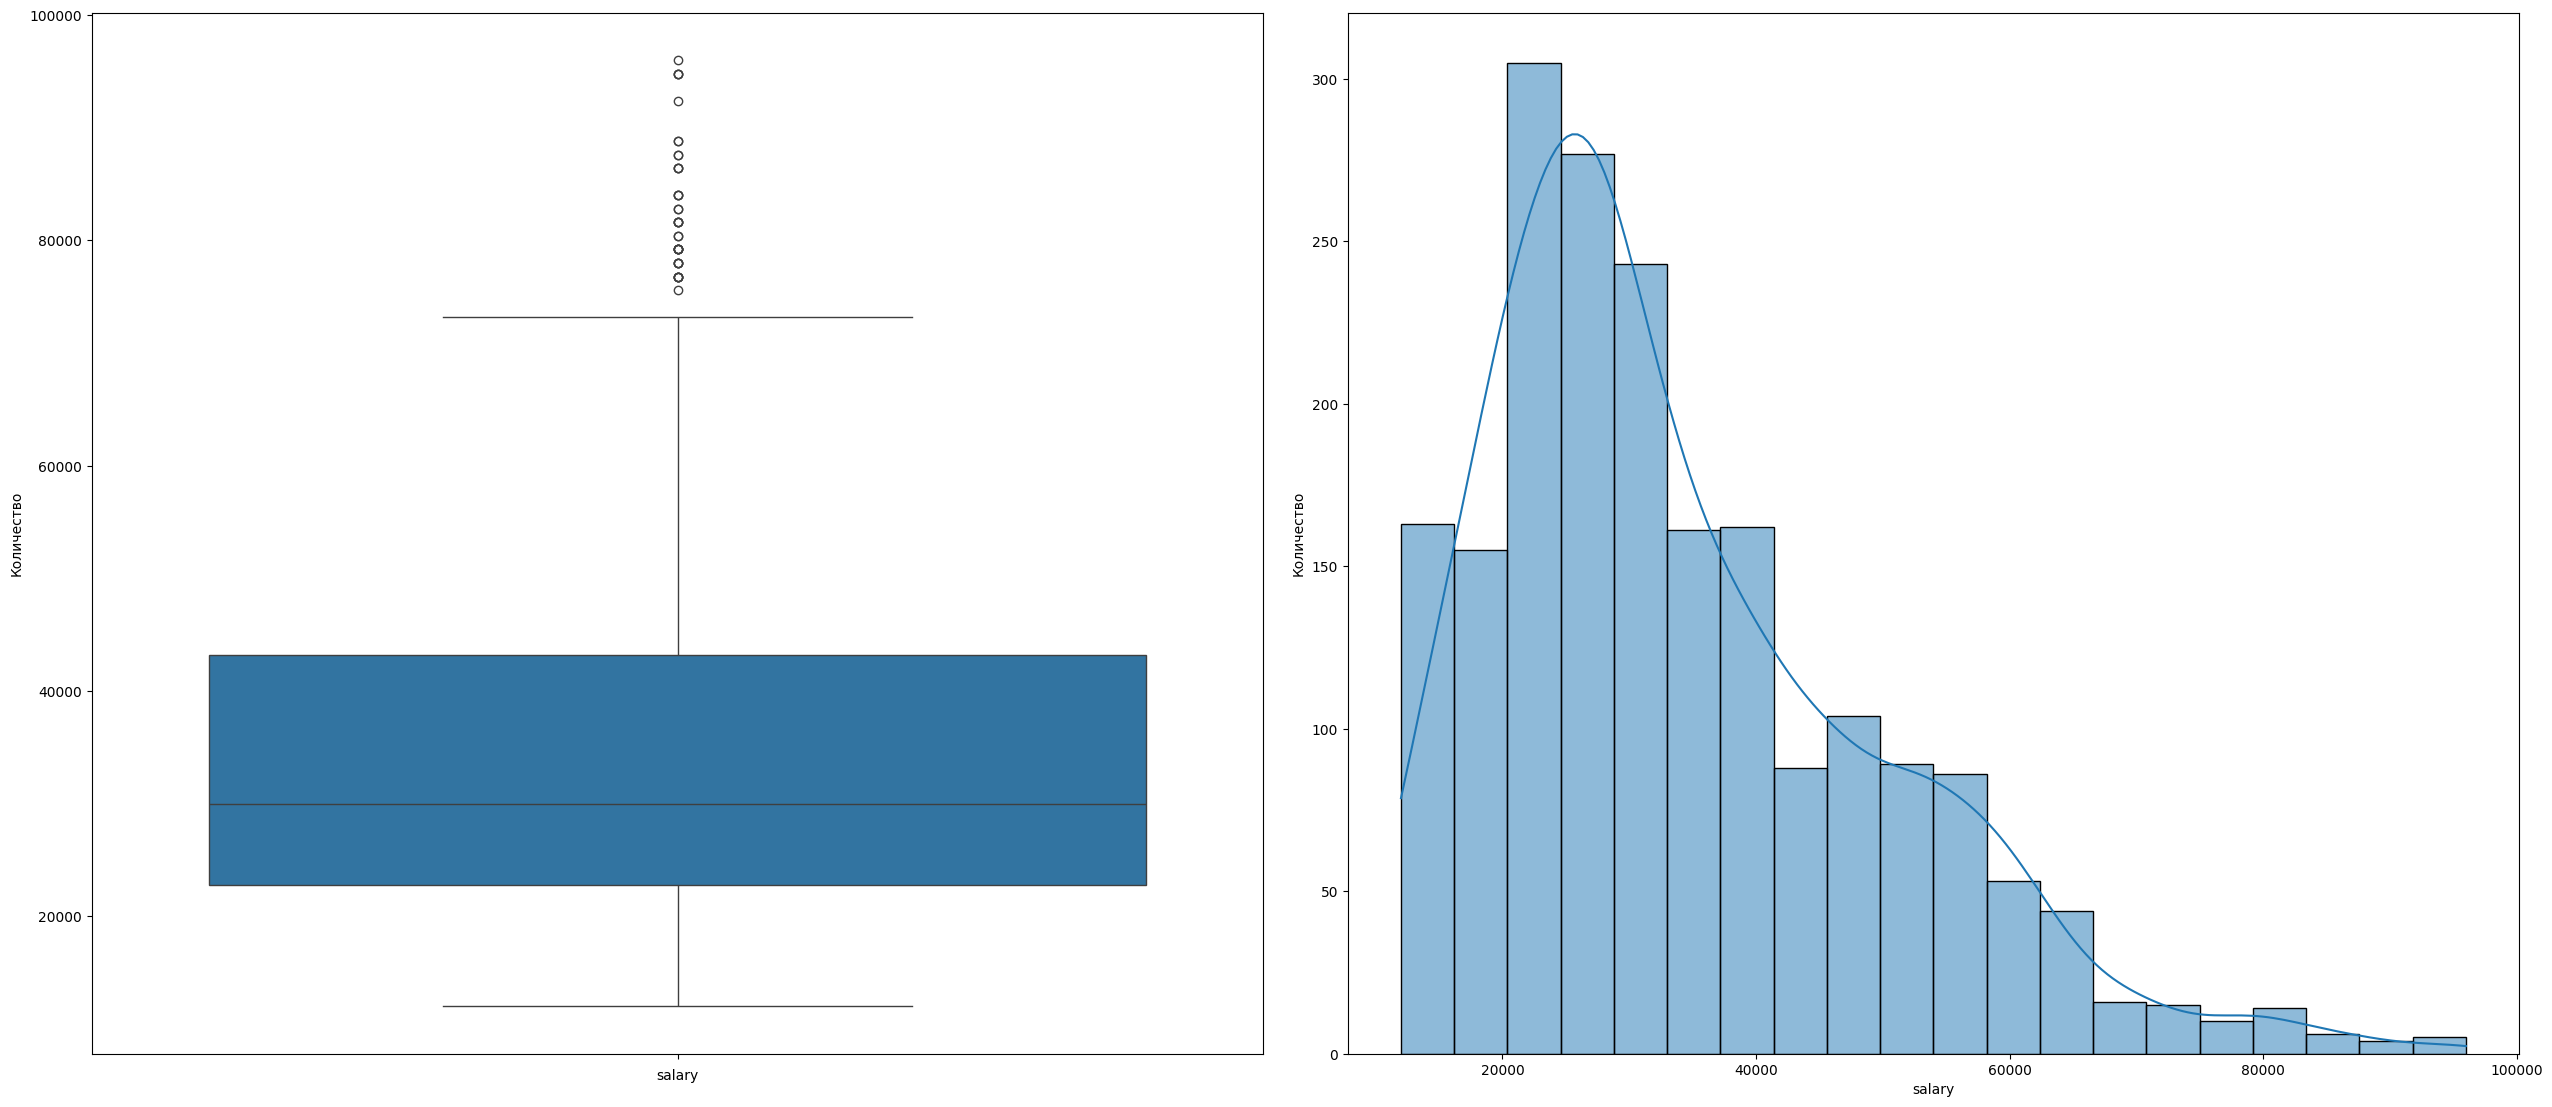

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)
"Пара графиков для таблицы df_test_target_job_satisfaction_rate


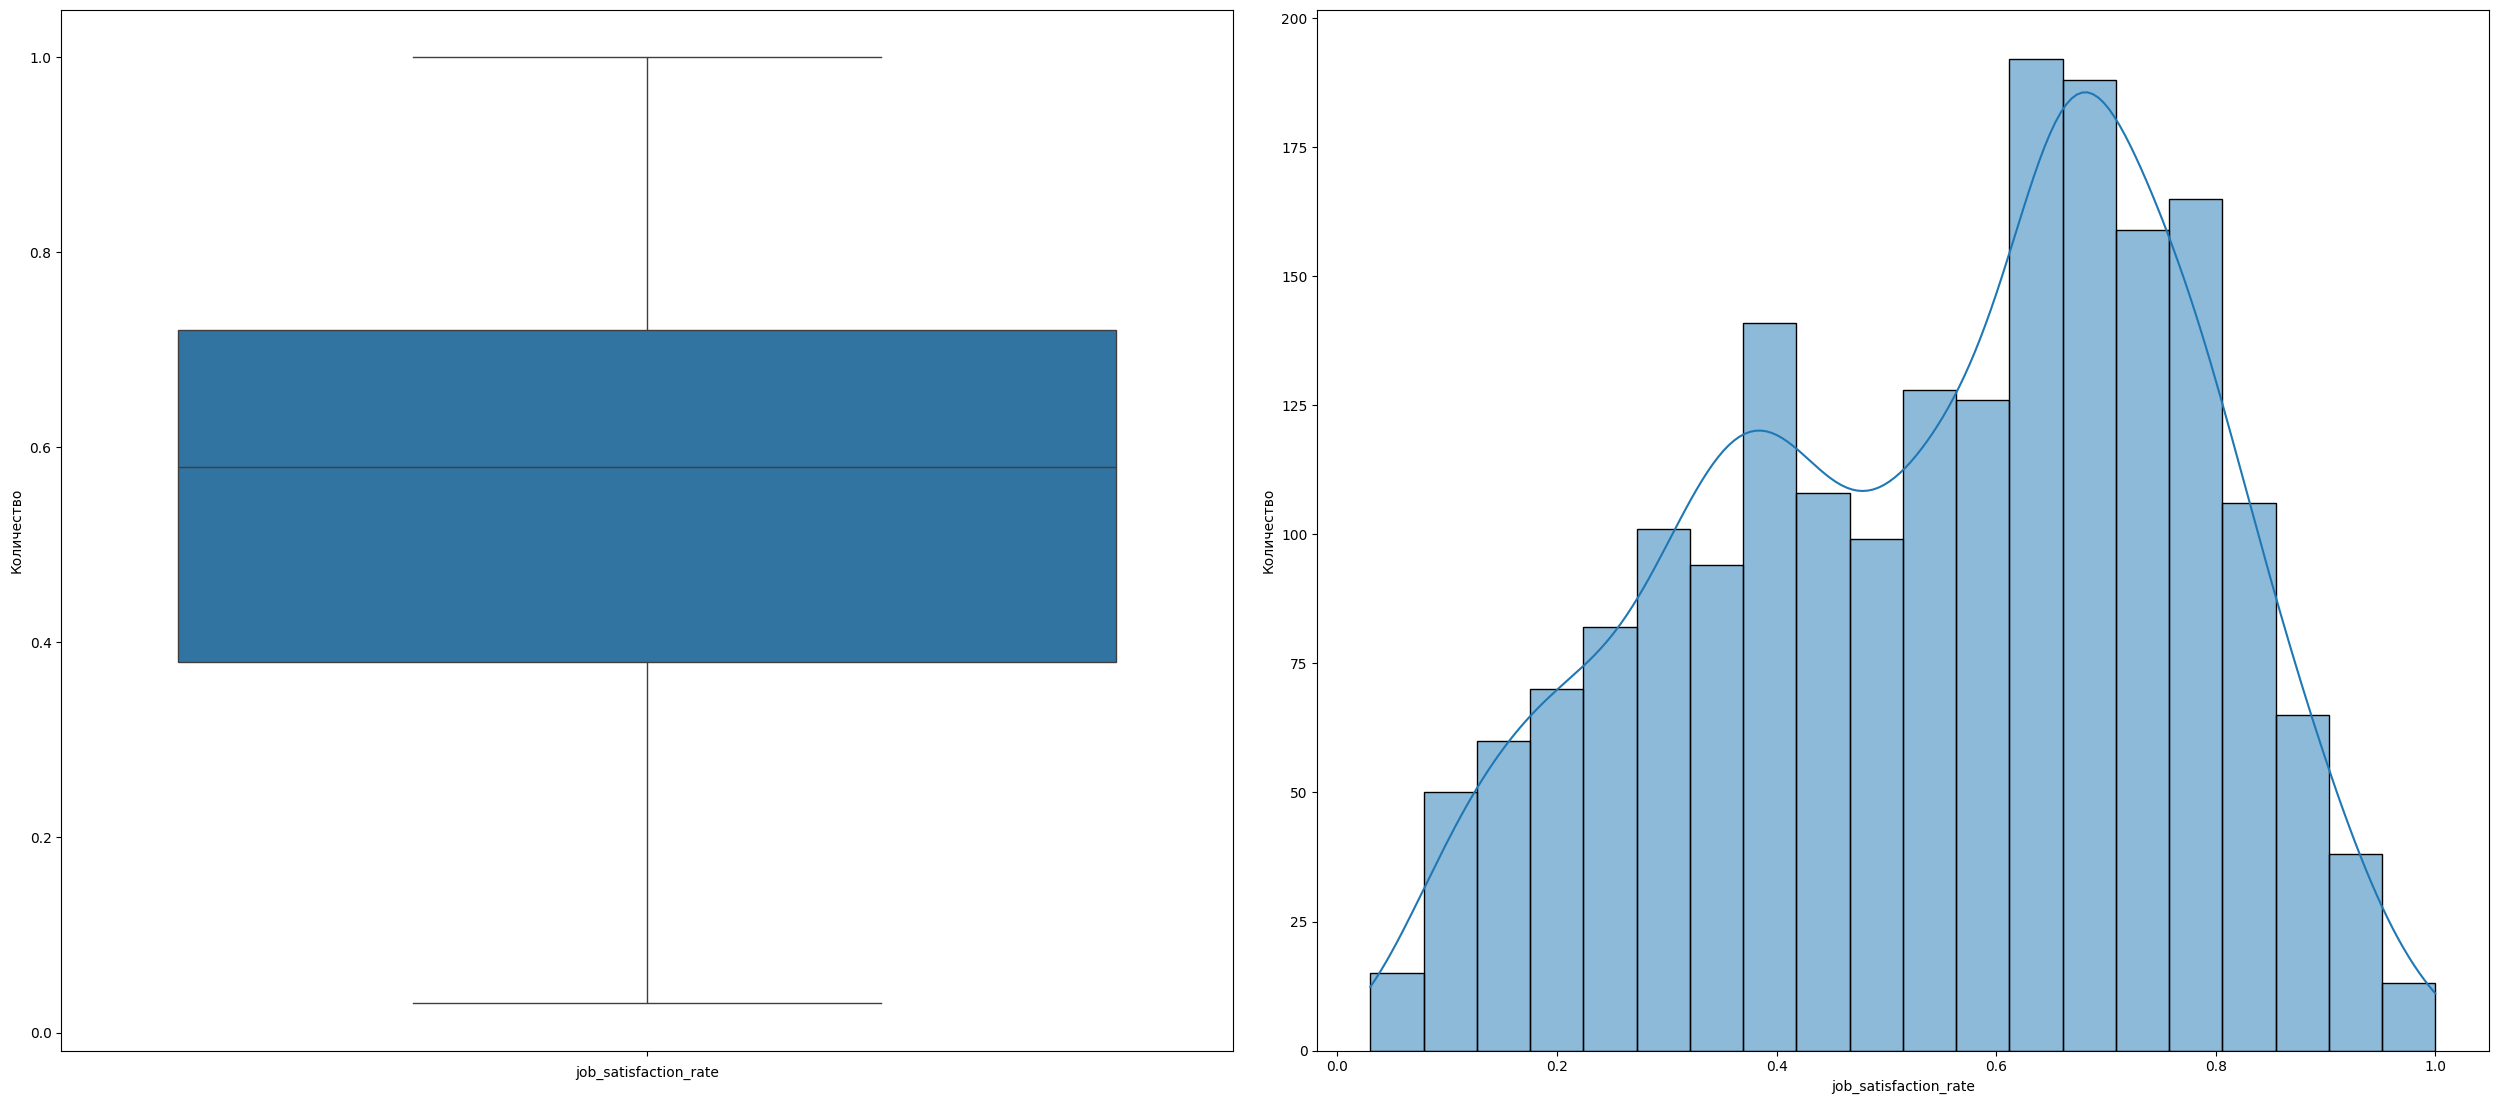

KstestResult(statistic=0.5263563925851722, pvalue=0.0, statistic_location=0.09, statistic_sign=-1)
"Пара графиков для таблицы df_test_target_quit
"Пара графиков для таблицы df_train_job_satisfaction_rate


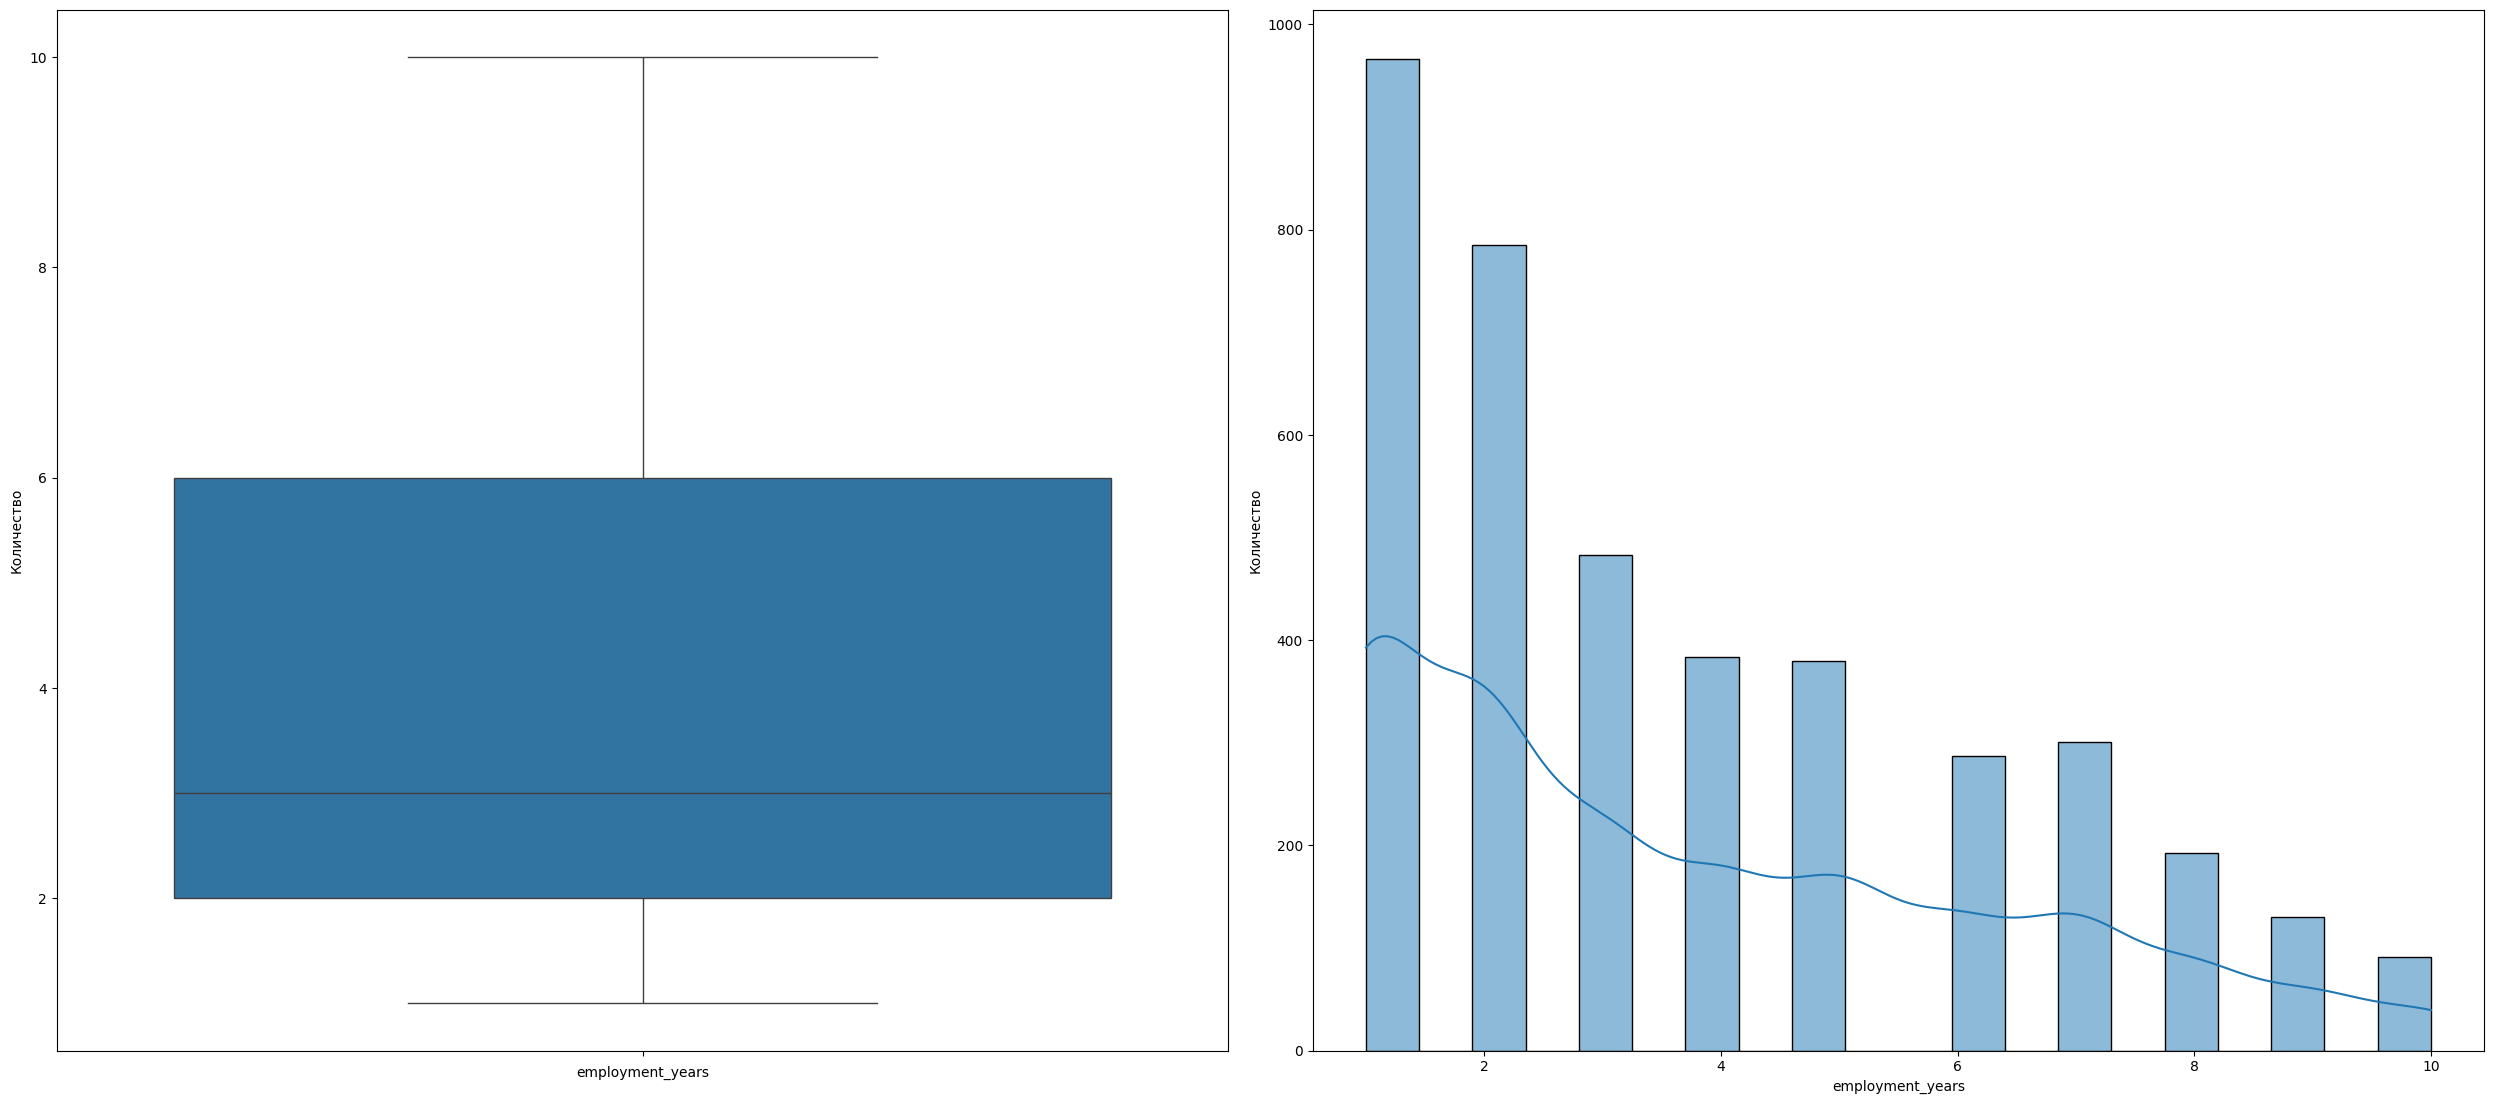

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


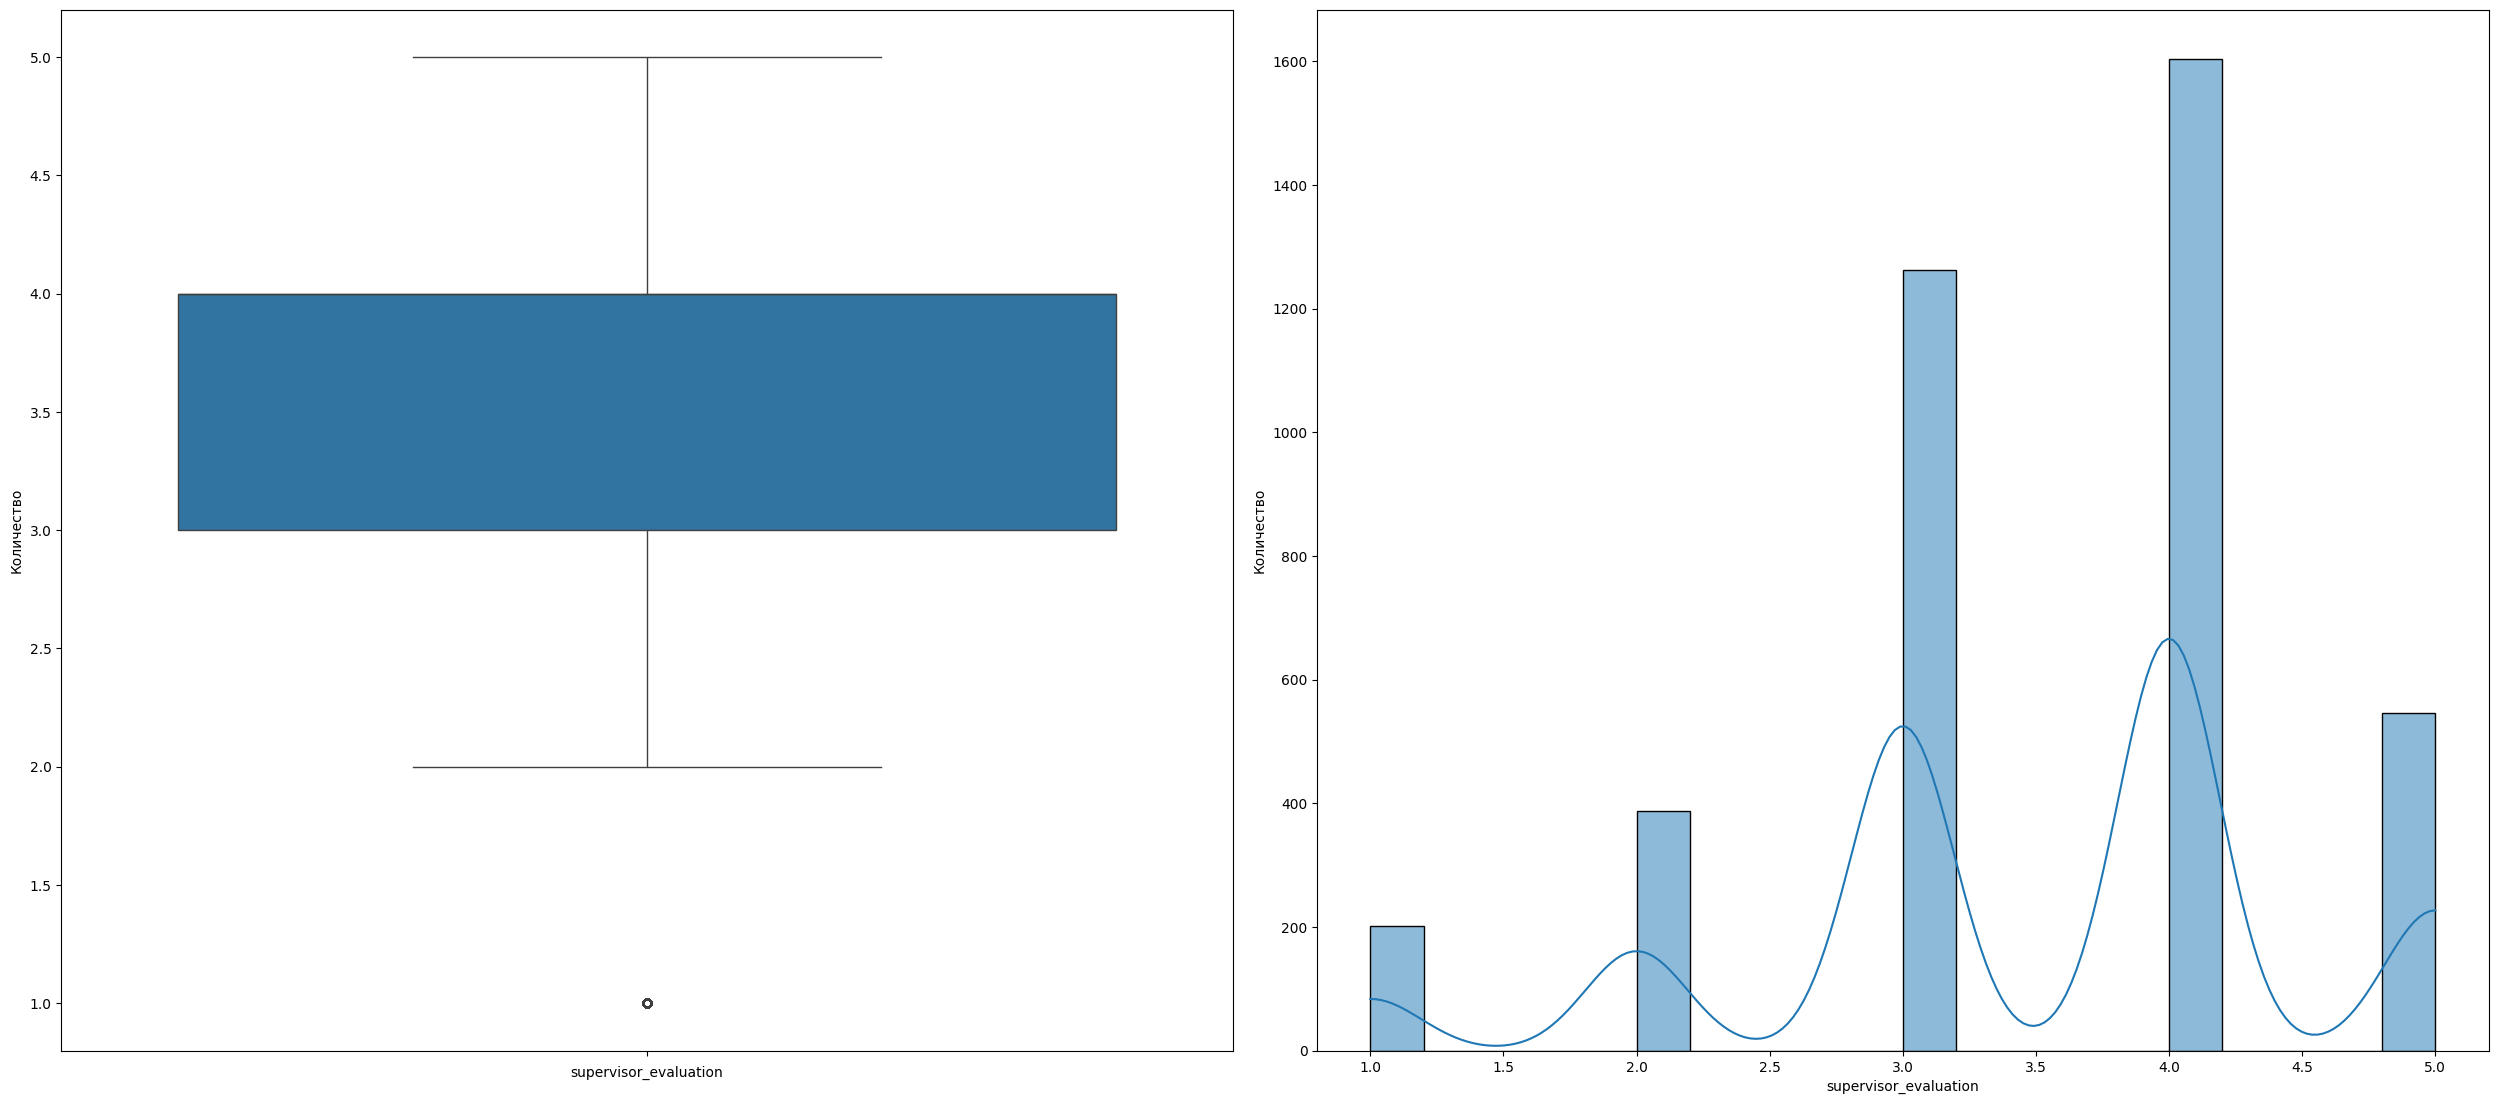

KstestResult(statistic=0.9269998680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


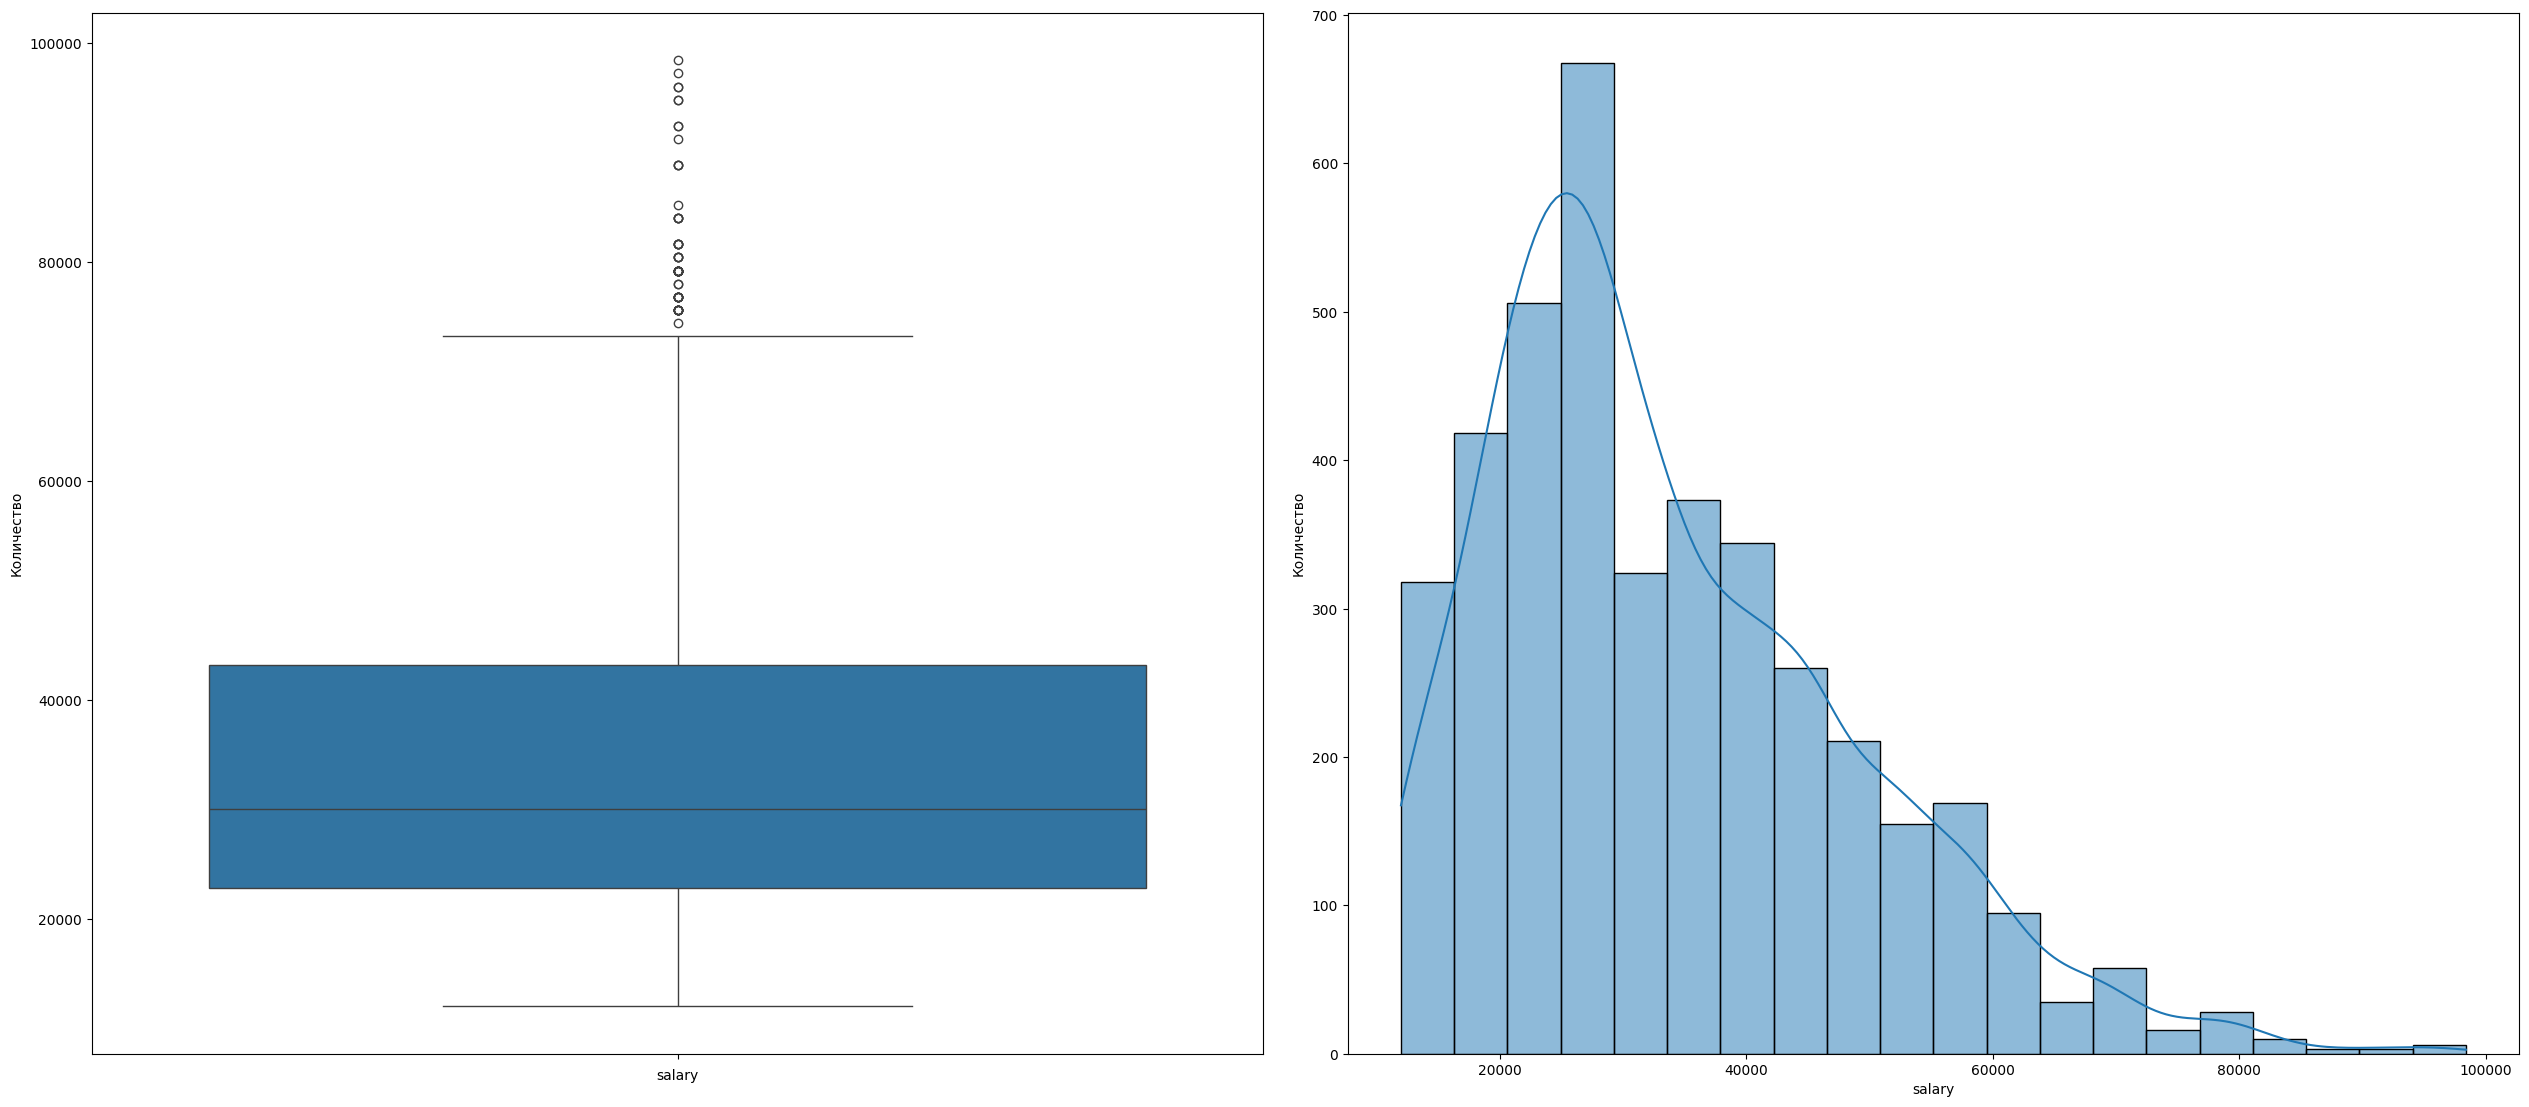

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)


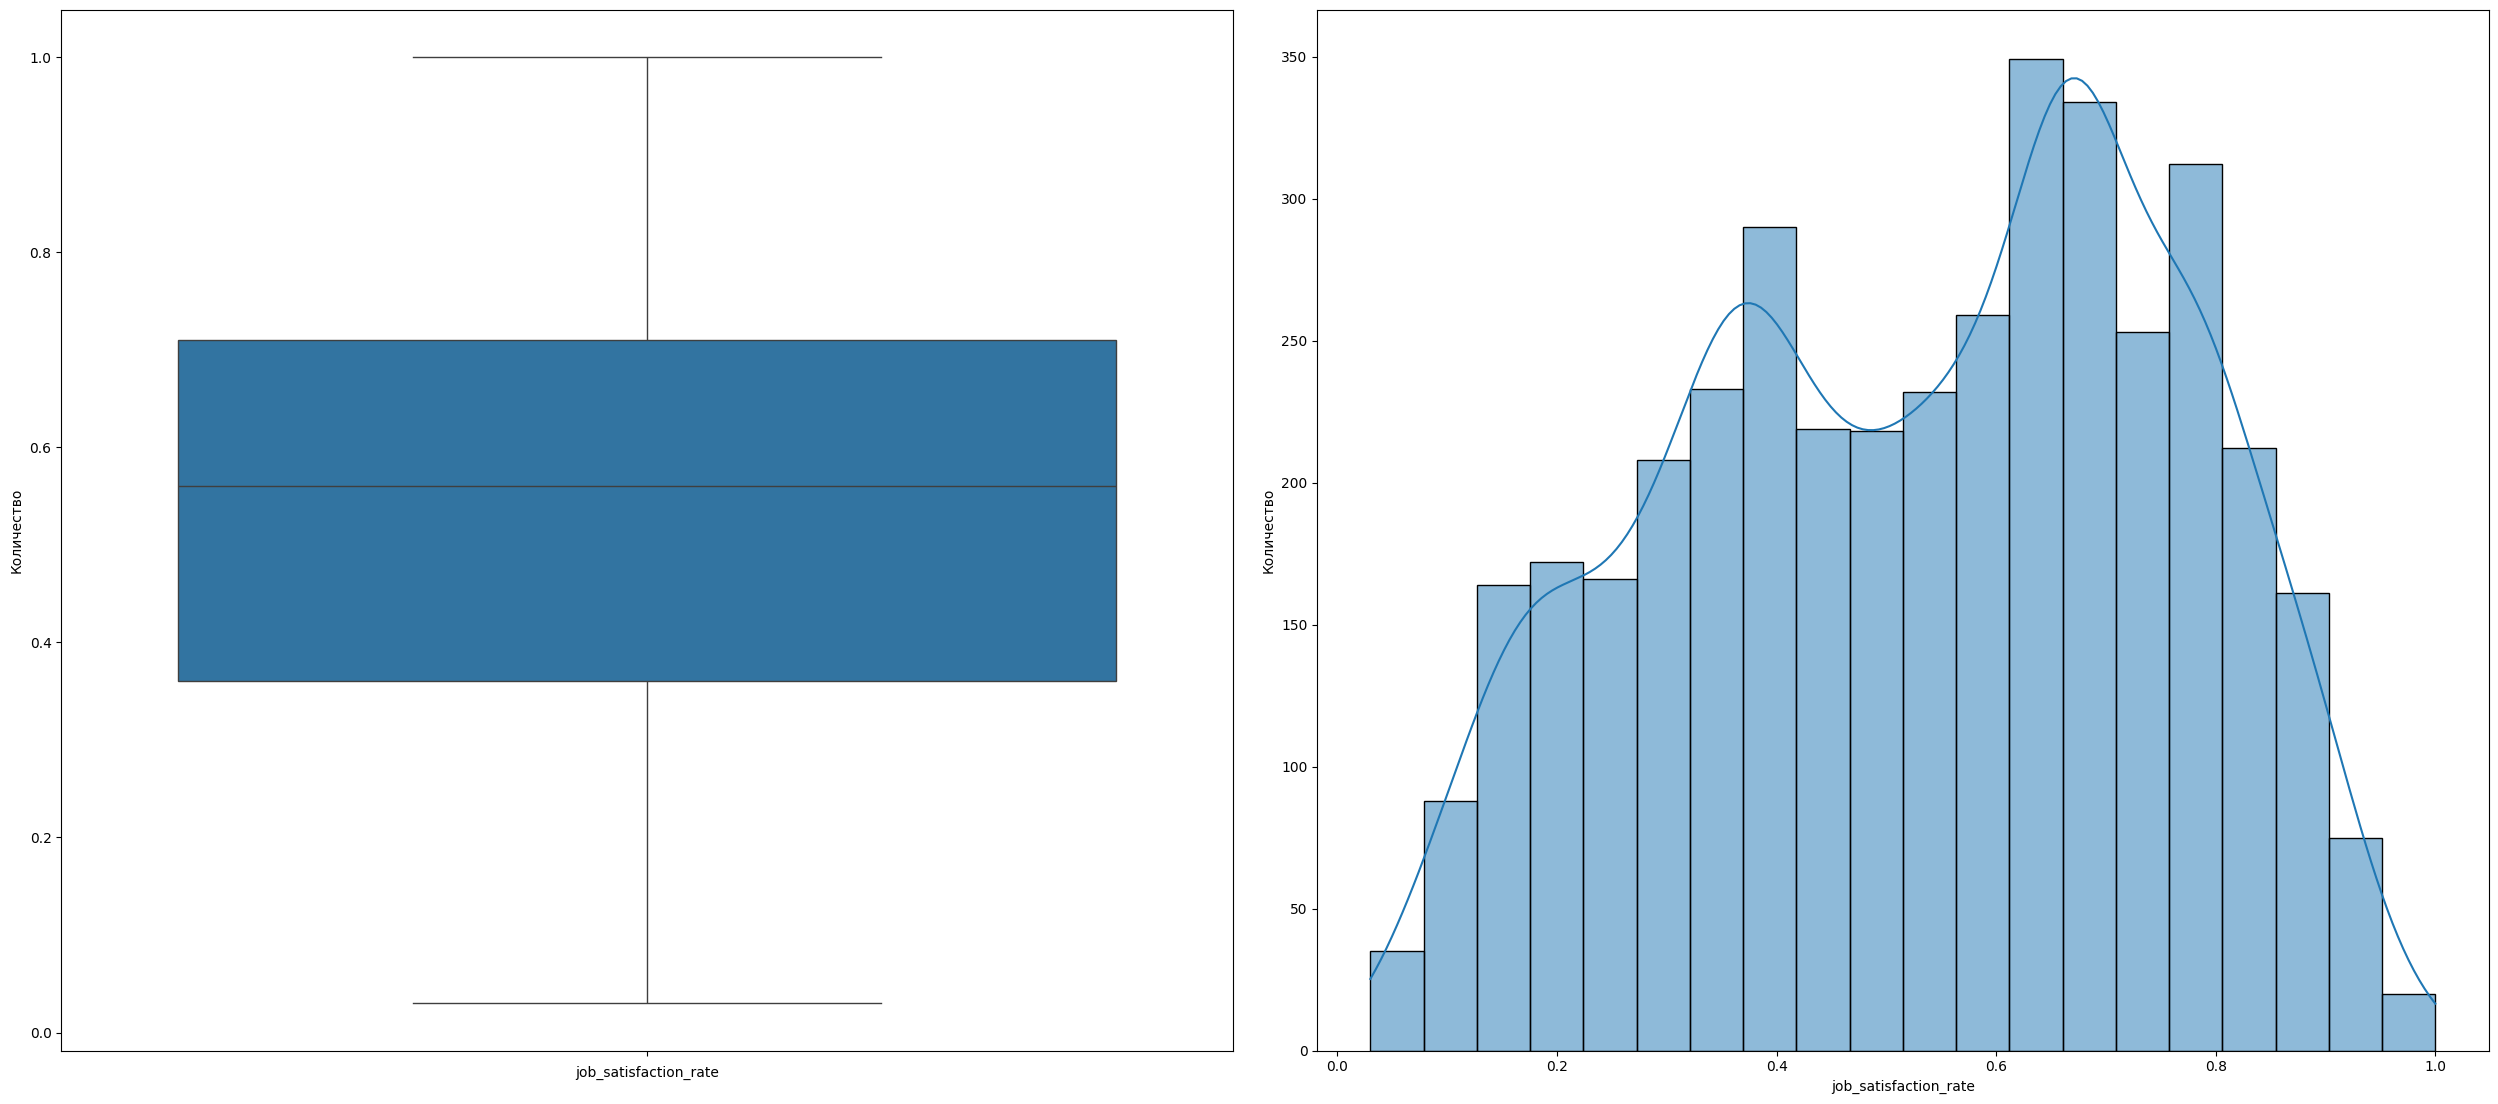

KstestResult(statistic=0.5241063925851721, pvalue=0.0, statistic_location=0.09, statistic_sign=-1)
"Пара графиков для таблицы df_train_quit


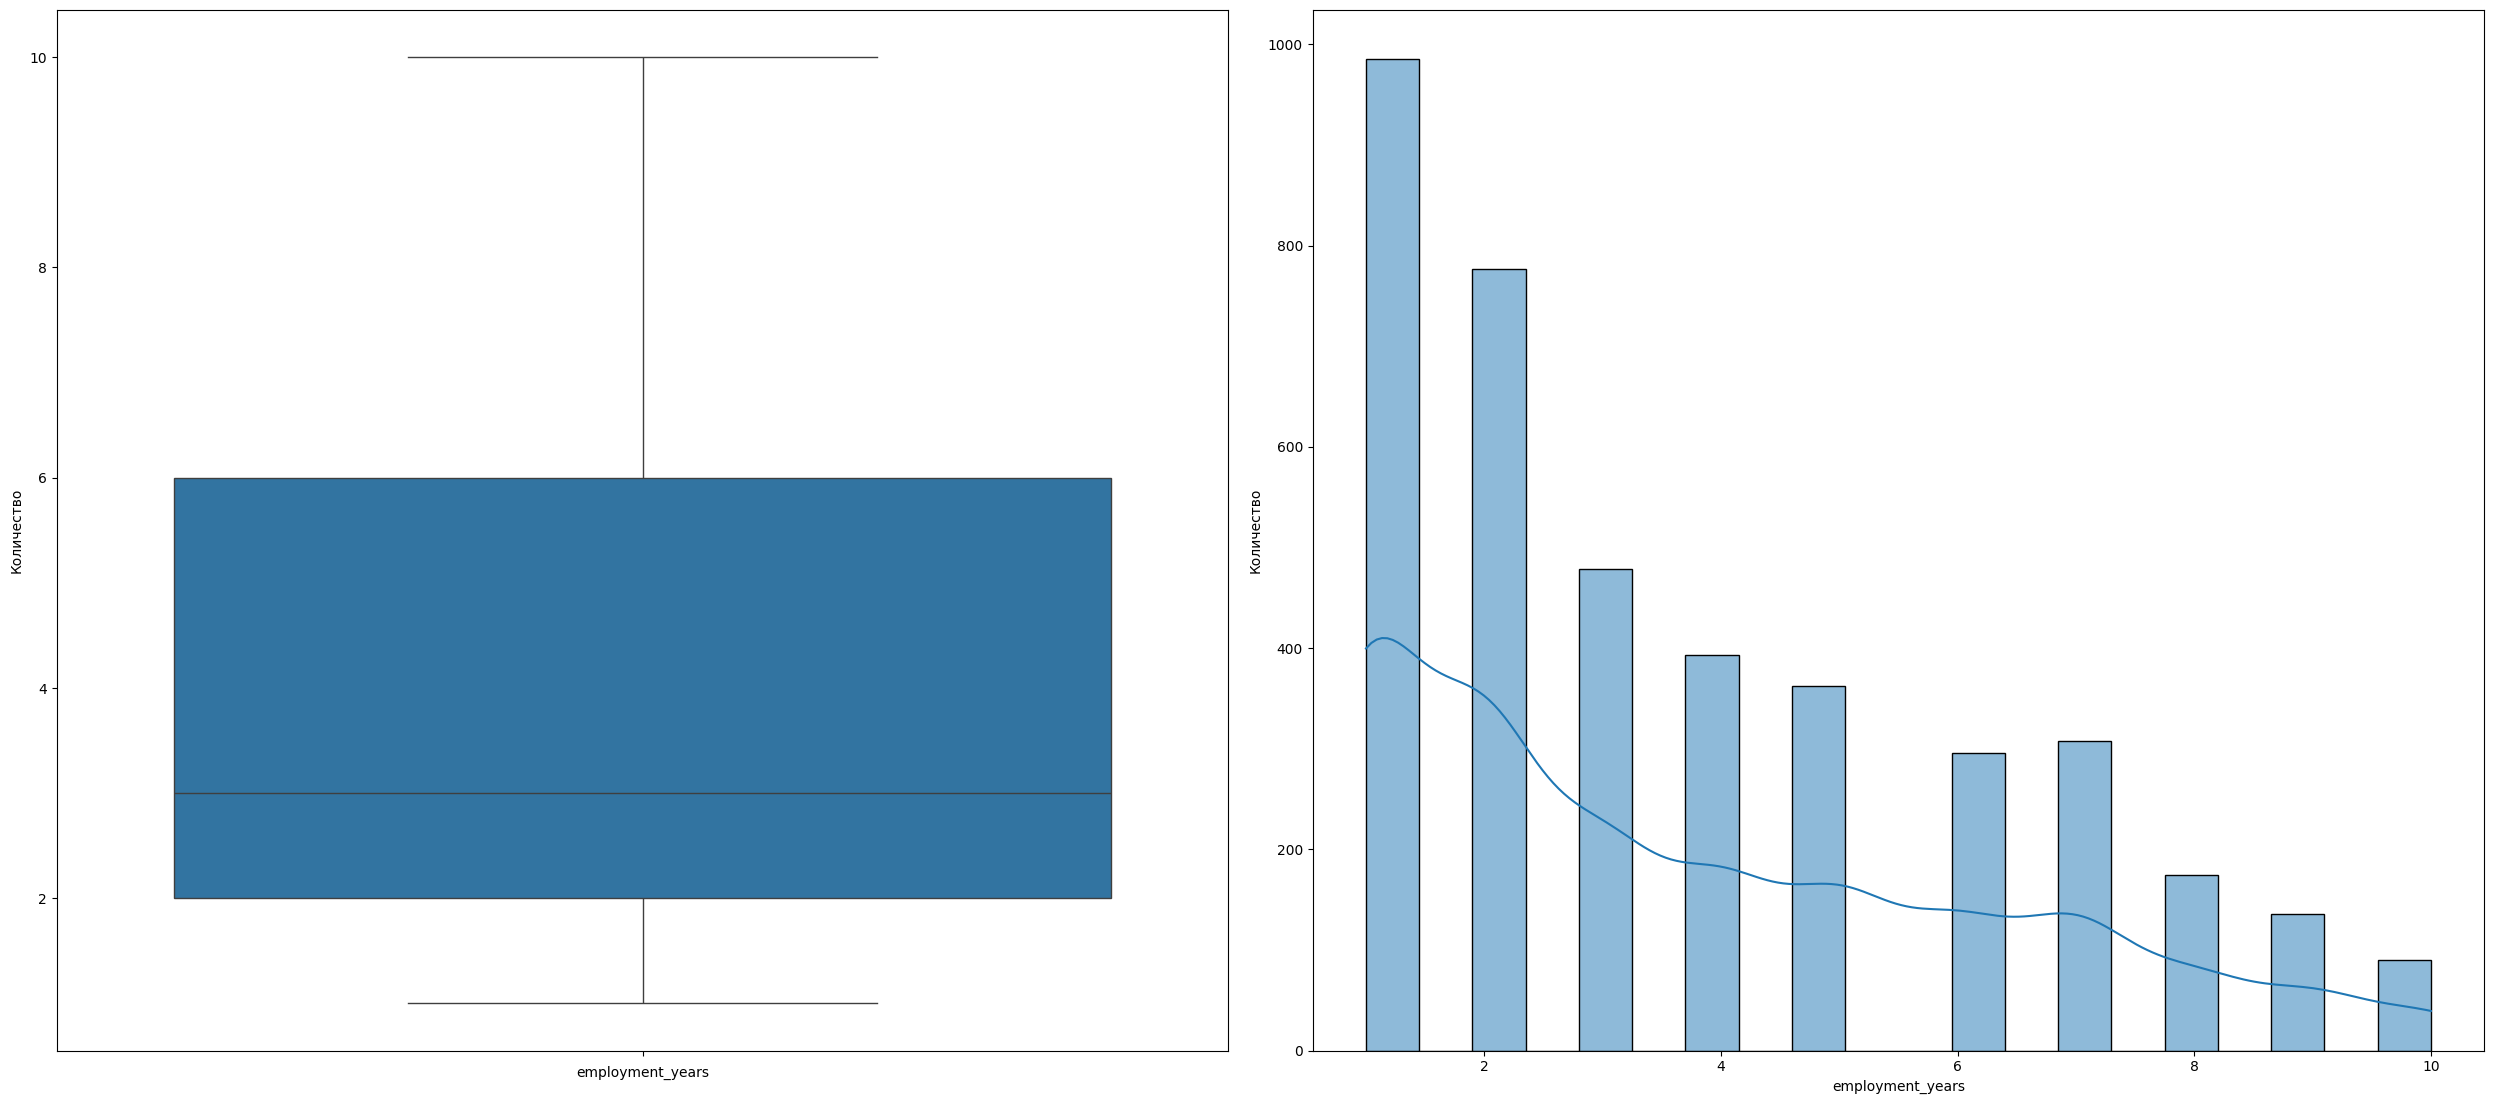

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


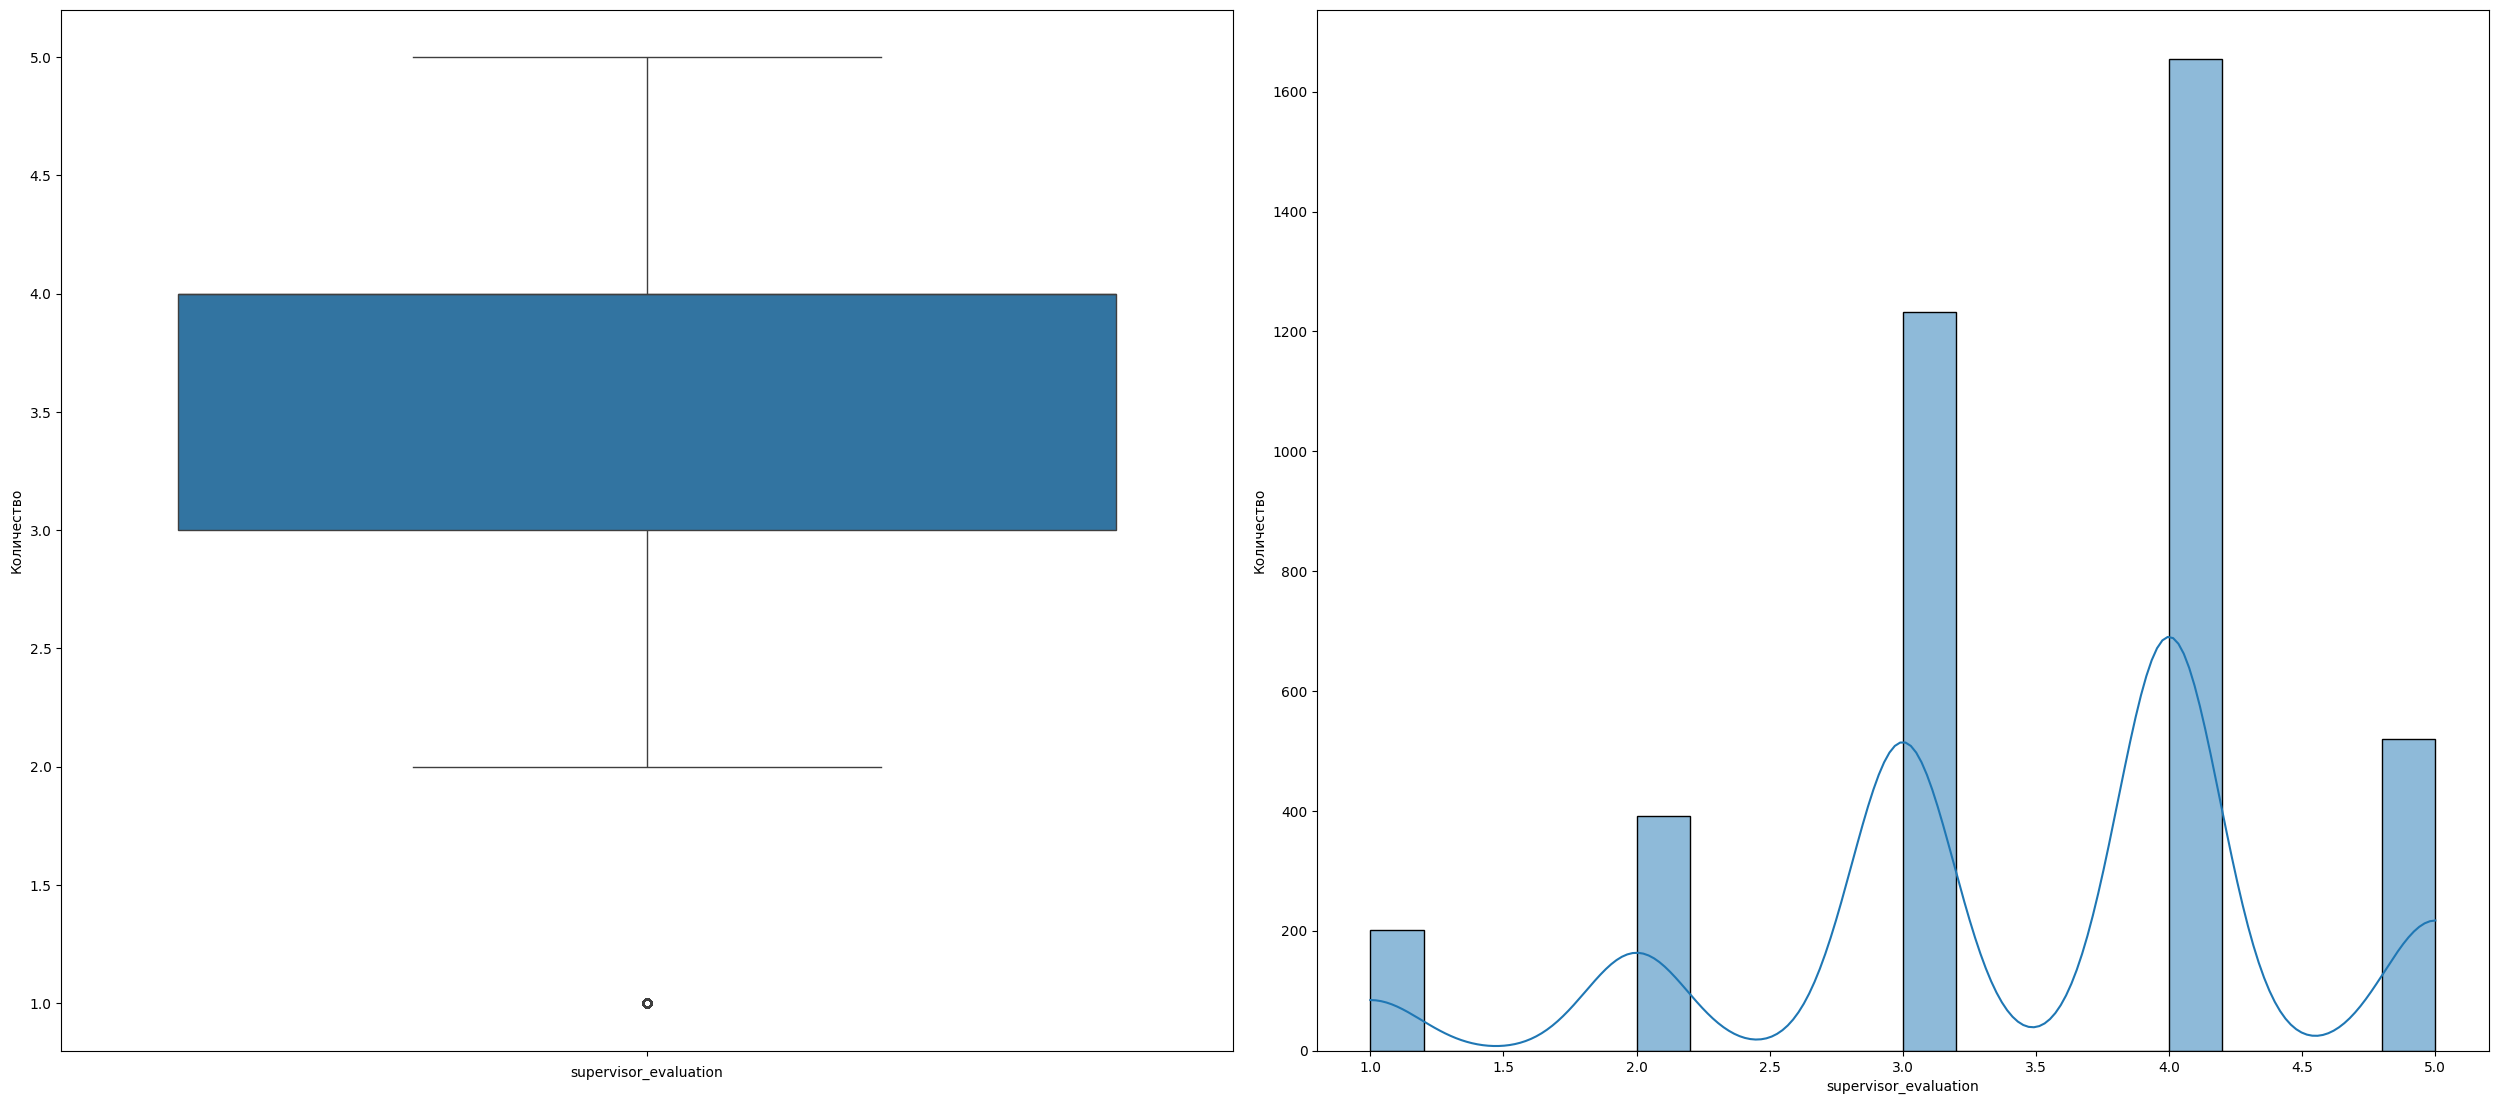

KstestResult(statistic=0.9267498680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


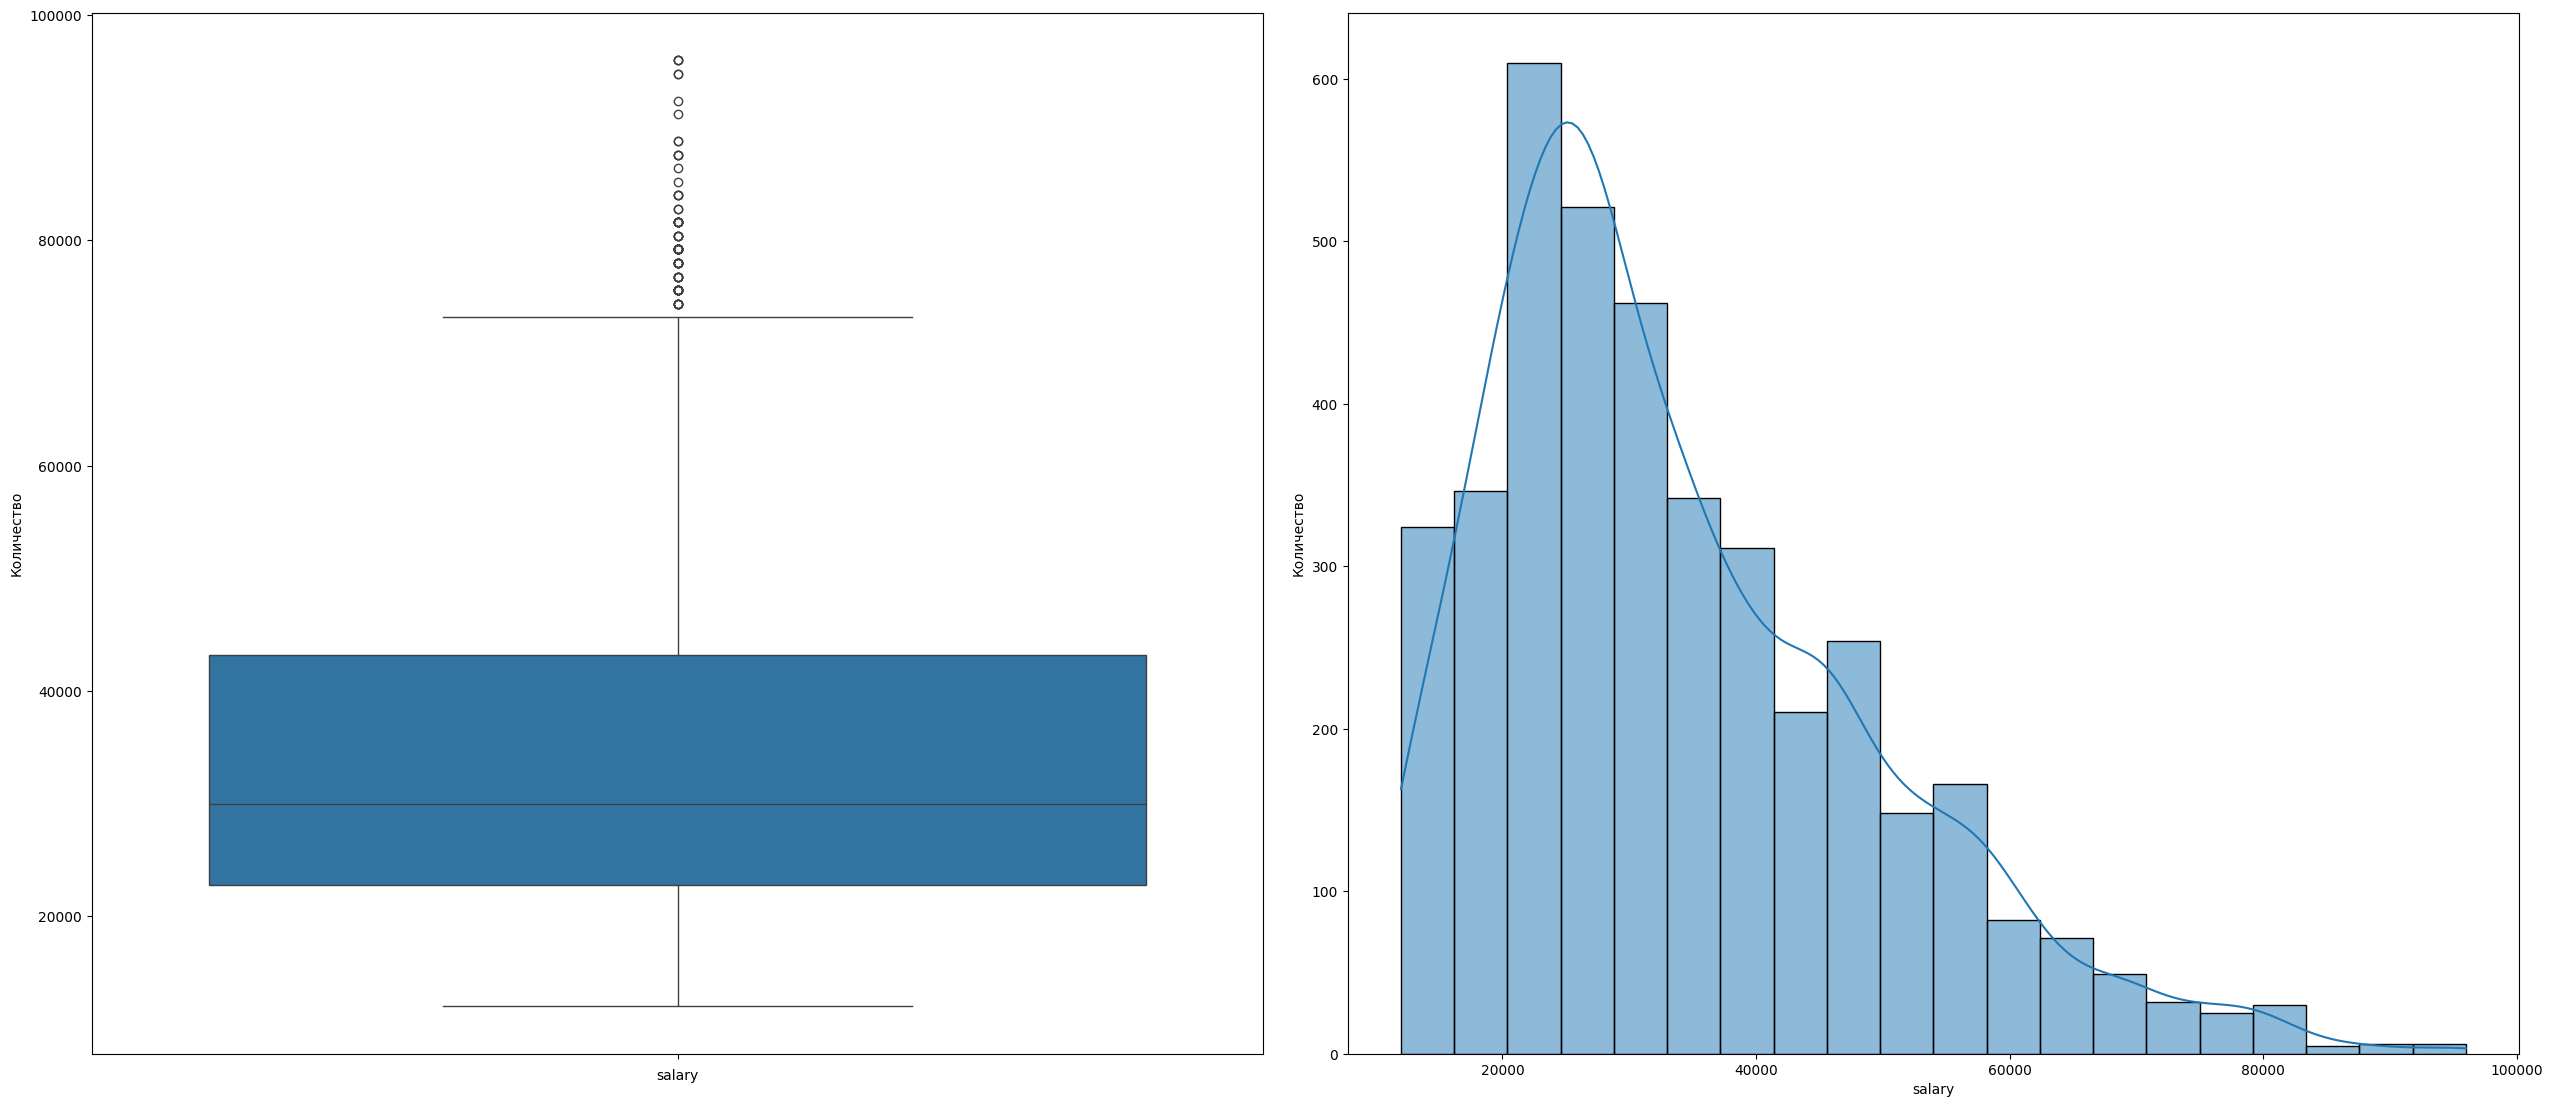

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)


In [173]:
for f in DF_NAMES[:5]:
    print(f'"Пара графиков для таблицы {f}')
    for c in globals()['col_num_' + f.strip('df_')]:
        if c != 'id':
            fig, axes = plt.subplots(1,2, figsize=(25, 11), constrained_layout=False)
            fig.tight_layout(h_pad=10,w_pad=3)
            axes = axes.ravel()
            ax = sns.boxplot(y=c, data=globals()[f], ax=axes[0])
            ax.set(xlabel=c, ylabel='Количество')
            ax = sns.histplot(x=c, data = globals()[f], bins=20, kde=True)
            ax.set(xlabel=c, ylabel='Количество')
            plt.show()
            print(kstest(globals()[f][c], 'norm'))

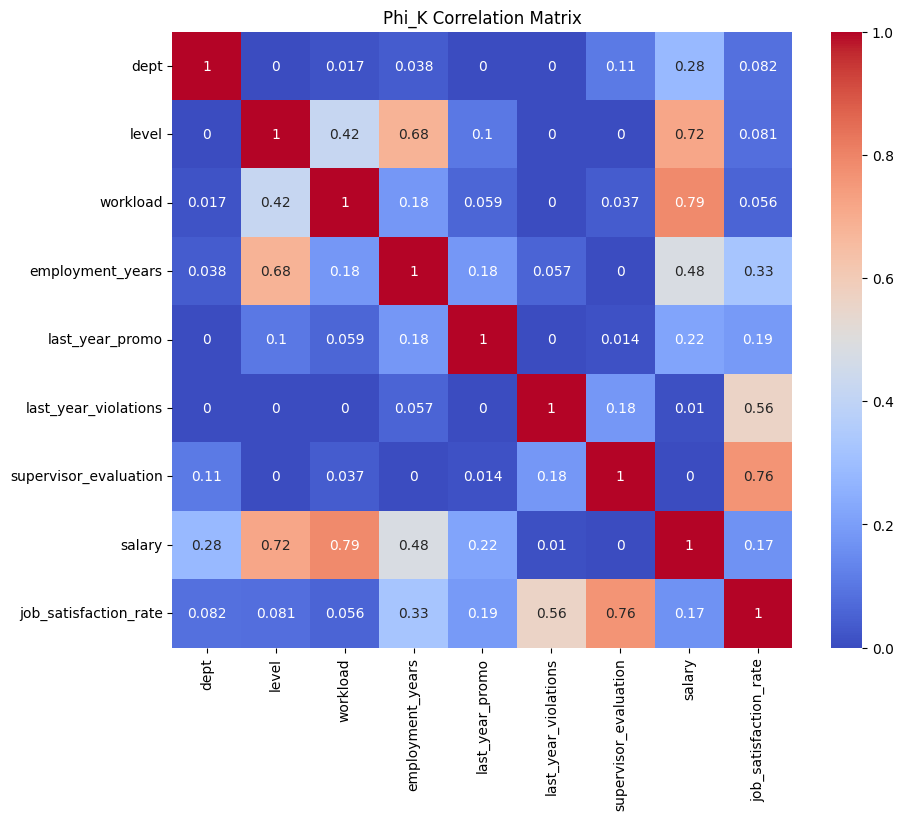

In [174]:
interval_cols = ['salary', 'job_satisfaction_rate']
df = df_train_job_satisfaction_rate.drop('id', axis = 1)
corr_matrix = df.phik_matrix(interval_cols= interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

В таблице ниже я опишу каждый признак, его категорию и подкатегорию.  

|  Имя признака  | Описание признака  | Тип признака  |  Подтип признака  |  
|:----|:----|:---:|:---:|
|  dept  |  отдел, в котором работает сотрудник  |  Категориальный  |  Номинальный  |  
|  level  |  уровень занимаемой должности  |  Категориальный  |  Порядковый  |  
|  workload  |  уровень загруженности сотрудника  |  Категориальный  |  Порядковый  |  
|  employment_years  |  длительность работы в компании (в годах)  |  Количественный  |  Дискретный  |  
|  last_year_promo  |  показывает, было ли повышение за последний год  |  Категориальный  |  Номинальный  |  
|  last_year_violations  |  показывает, нарушал ли сотрудник трудовой договор за последний год  |  Категориальный  |  Номинальный  |  
|  supervisor_evaluation  |  оценка качества работы сотрудника, которую дал руководитель  |  Количественный  |  Дискретный  |  
|  salary  |  ежемесячная зарплата сотрудника  |  Количественный  |  Непрерывный  |  
|  job_satisfaction_rate  |  уровень удовлетворённости сотрудника работой в компании, целевой признак  |  Количественный  |  Непрерывный  |  

Выводом станет распределение имен колонок по спискам в константах, которые будут в дальнейшем использованы в паплайнах.

In [175]:
OHE_COLUMNS = ['dept', 'last_year_promo', 'last_year_violations']
ORD_COLUMNS = ['level', 'workload']
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary']

#### Построю диаграмму рассеяния для зависимости целевого признака от признаков.

The figure layout has changed to tight


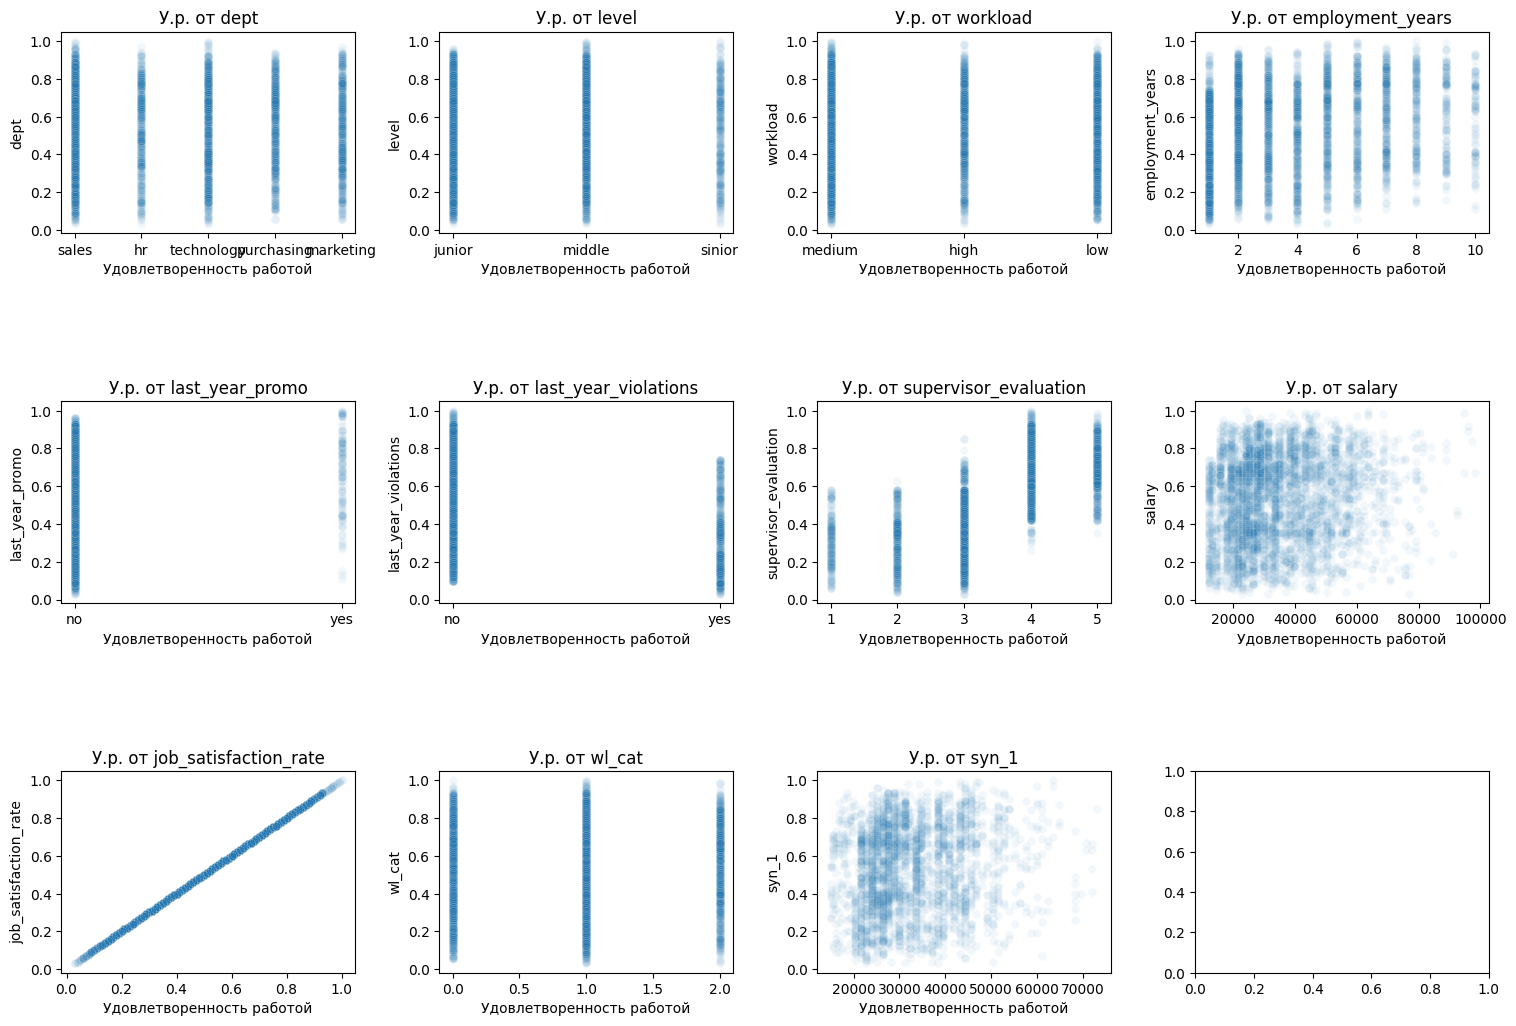

In [177]:
x=0
fig, axes = plt.subplots(3,4, figsize=(15, 10), constrained_layout=True)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()
for col in df_train_job_satisfaction_rate.columns.to_list()[1:]:
    ax = sns.scatterplot(data=df_train_job_satisfaction_rate, y='job_satisfaction_rate', x=col, ax=axes[x], alpha=0.06)
    ax.set(xlabel='Удовлетворенность работой', ylabel=col, title=('У.р. от ' + col))
    #sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, -0.19), ncol=3, title=MAIN_CAT_COL[c], frameon=True)
    x+=1

<a id='t004'></a>  
#  4. Подготовка данных

Исправлю дисбаланс в наборе данных

from imblearn.over_sampling import SMOTETomek

sampler = SMOTETomek(random_state=42)
X_resample, y_resample = sampler.fit_resample(X, y) 

Объявлю конвеер для OneHotEncoder

In [178]:
r_o_s = RandomOverSampler(random_state = RANDOM_STATE)

In [179]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

Объявлю конвеер для OrdinalEncoder

In [180]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Собираю все вместе и добавляю обработку численных признаков MinMaxScaler'ом

In [181]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS),
        ('num', MinMaxScaler(), NUM_COLUMNS)
    ], 
    remainder='passthrough'
) 

<a id='t005'></a>  
#  5. Обучение моделей

Объявлю метрику из заранее созданной функции

In [182]:
smape_score = make_scorer(smape, greater_is_better=False)

Объявлю словарь гиперпараметров моделей

In [183]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    #{
    #    'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
    #    'models__max_depth': range(2, 5),
    #    'models__max_features': range(2, 5),
    #    'models__criterion' : ['gini', 'entropy'],
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    #},
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300), 
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }#,
    #{
    #    'models': [SVC(
    #        random_state=RANDOM_STATE)],
    #    #'models__C': [0.1, 1, 10, 100, 1000],  
    #    #'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    #    'models__kernel': ['linear'],
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   #}
]

Итоговый паплайн

In [184]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        #('ros', r_o_s),
        ('models', LinearRegression())#DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Определю автоматический поиск моделей через RandomizedSearchCV

In [185]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Выделю из тренировочной выбоки целевые признаки

In [186]:
df_test_features = df_test_features.drop(['id'], axis = 1)

In [187]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id', 'wl_cat', 'syn_1'], axis = 1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate'] * 100
y_train = y_train.astype({'job_satisfaction_rate': int})
y_test = df_test_target_job_satisfaction_rate['job_satisfaction_rate']* 100
y_test = y_test.astype({'job_satisfaction_rate': int})

Кодирую целевые признаки

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(df_test_target_job_satisfaction_rate['job_satisfaction_rate'])

print(dict(zip(le.classes_, le.transform(le.classes_))))

In [190]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [191]:
#print("\n The best estimator across ALL searched params:\n", randomized_search.best_estimator_)
print("\n The best score across ALL searched params:\n", randomized_search.best_score_)
print("\n The best parameters across ALL searched params:\n", randomized_search.best_params_)


 The best score across ALL searched params:
 -14.195486641098677

 The best parameters across ALL searched params:
 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 263, 'models__max_depth': 142, 'models': DecisionTreeRegressor(random_state=42)}


In [192]:
y_test_pred = randomized_search.predict(df_test_features)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred):.2f}')

Метрика SMAPE на тестовой выборке: 49.51


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [193]:
print(y_test_pred)

[82.4        66.79411765 65.22222222 ... 18.59615385 47.93333333
 52.6       ]
